In [5]:
import numpy as np
import pandas as pd
import datetime
import urllib
import json
from sklearn.decomposition import PCA
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%pylab inline


Populating the interactive namespace from numpy and matplotlib


C:\Users\Nurvirta\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Polygon', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Load Data

In [10]:
nyc_coll = pd.read_csv('NYC_collision_2.csv')

In [11]:
nyc_coll['date'] = pd.to_datetime(nyc_coll['date'])
nyc_coll['yearmonth'] = nyc_coll['date'].map(lambda x: 100*x.year + x.month)
nyc_coll.head()

,Unnamed: 0,date,time,hour,dayofweek,year,pedestrian_injured,cyclist_injured,motorist_injured,pedestrian_killed,cyclist_killed,motorist_killed,vehicle,lat,long,contributing_factor,yearmonth
0,0,2015-04-04,9:25,9,5,2015,0,0,0,0,0,0,PICK-UP TRUCK,40.750788,-74.005630,Prescription Medication,201504
1,1,2015-04-04,21:15,21,5,2015,0,0,1,0,0,0,PASSENGER VEHICLE,40.781291,-73.814200,Failure to Yield Right-of-Way,201504
2,2,2015-04-04,16:52,16,5,2015,0,0,0,0,0,0,PASSENGER VEHICLE,40.702595,-73.855293,Turning Improperly,201504
3,3,2015-04-04,9:30,9,5,2015,0,0,0,0,0,0,PASSENGER VEHICLE,40.804886,-73.962474,Unspecified,201504
4,4,2015-04-04,9:41,9,5,2015,0,0,0,0,0,0,PASSENGER VEHICLE,40.715144,-73.749356,Outside Car Distraction,201504


# Function to Visualize Data by YEAR

In [12]:
def plotYearly(df, title,alpha):
    fig = plt.figure(figsize=(30,10))
    plt.suptitle(title, fontsize=30)
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        df_year = df[df['year']==2012+i]
        pts = np.array(df_year.loc[:,['long','lat']].astype(float))
        ax.scatter(pts[:,0],pts[:,1], lw=0, color='k',alpha=alpha)
        ax.set_title(str(2012+i), fontsize=20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
    plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=6)

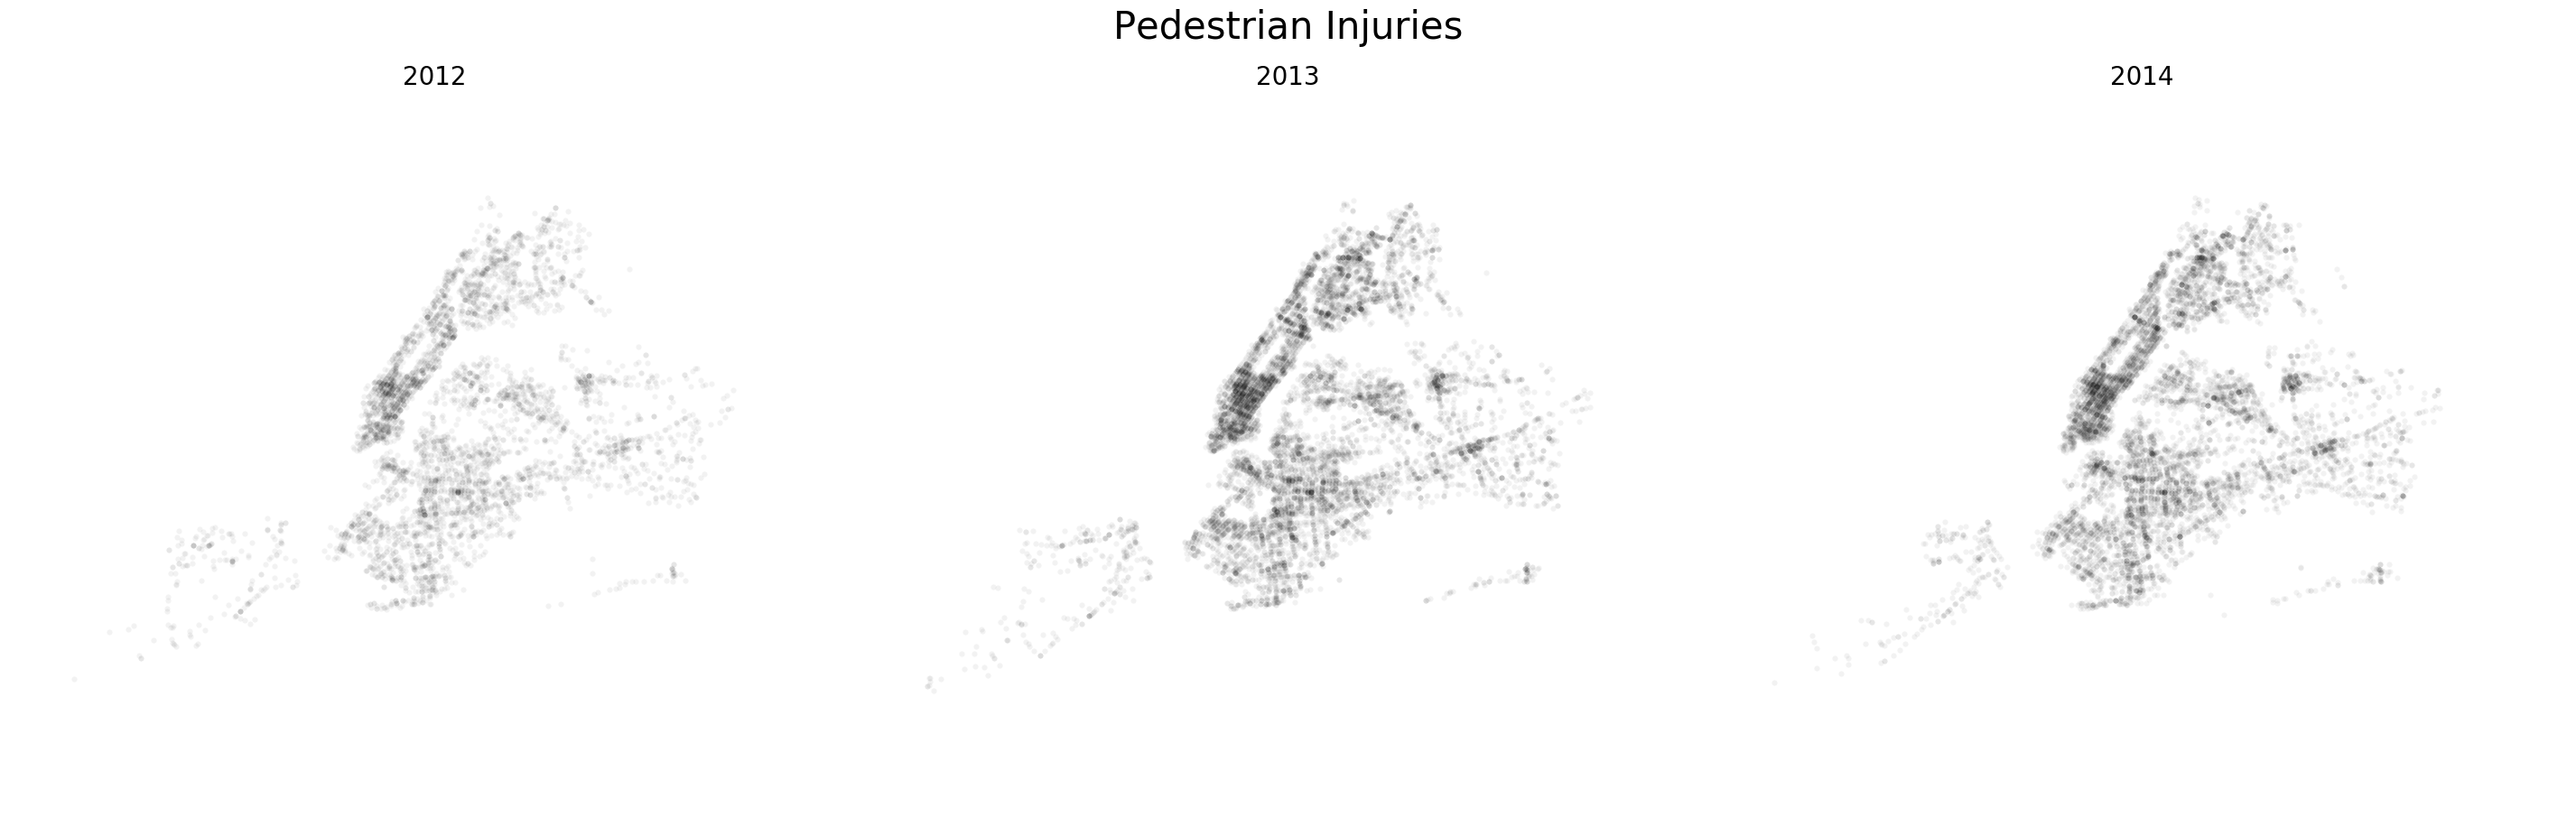

In [13]:
# SUBSET DATA FIRST
nyc_coll_original = nyc_coll.copy()
nyc_coll = nyc_coll[(nyc_coll.year>=2012)&(nyc_coll.year<=2014)]
ped = nyc_coll[(nyc_coll.pedestrian_injured > 0)]
ped_died = nyc_coll[nyc_coll.pedestrian_killed > 0]

# VISUALIZE
plotYearly(ped, 'Pedestrian Injuries',0.05)

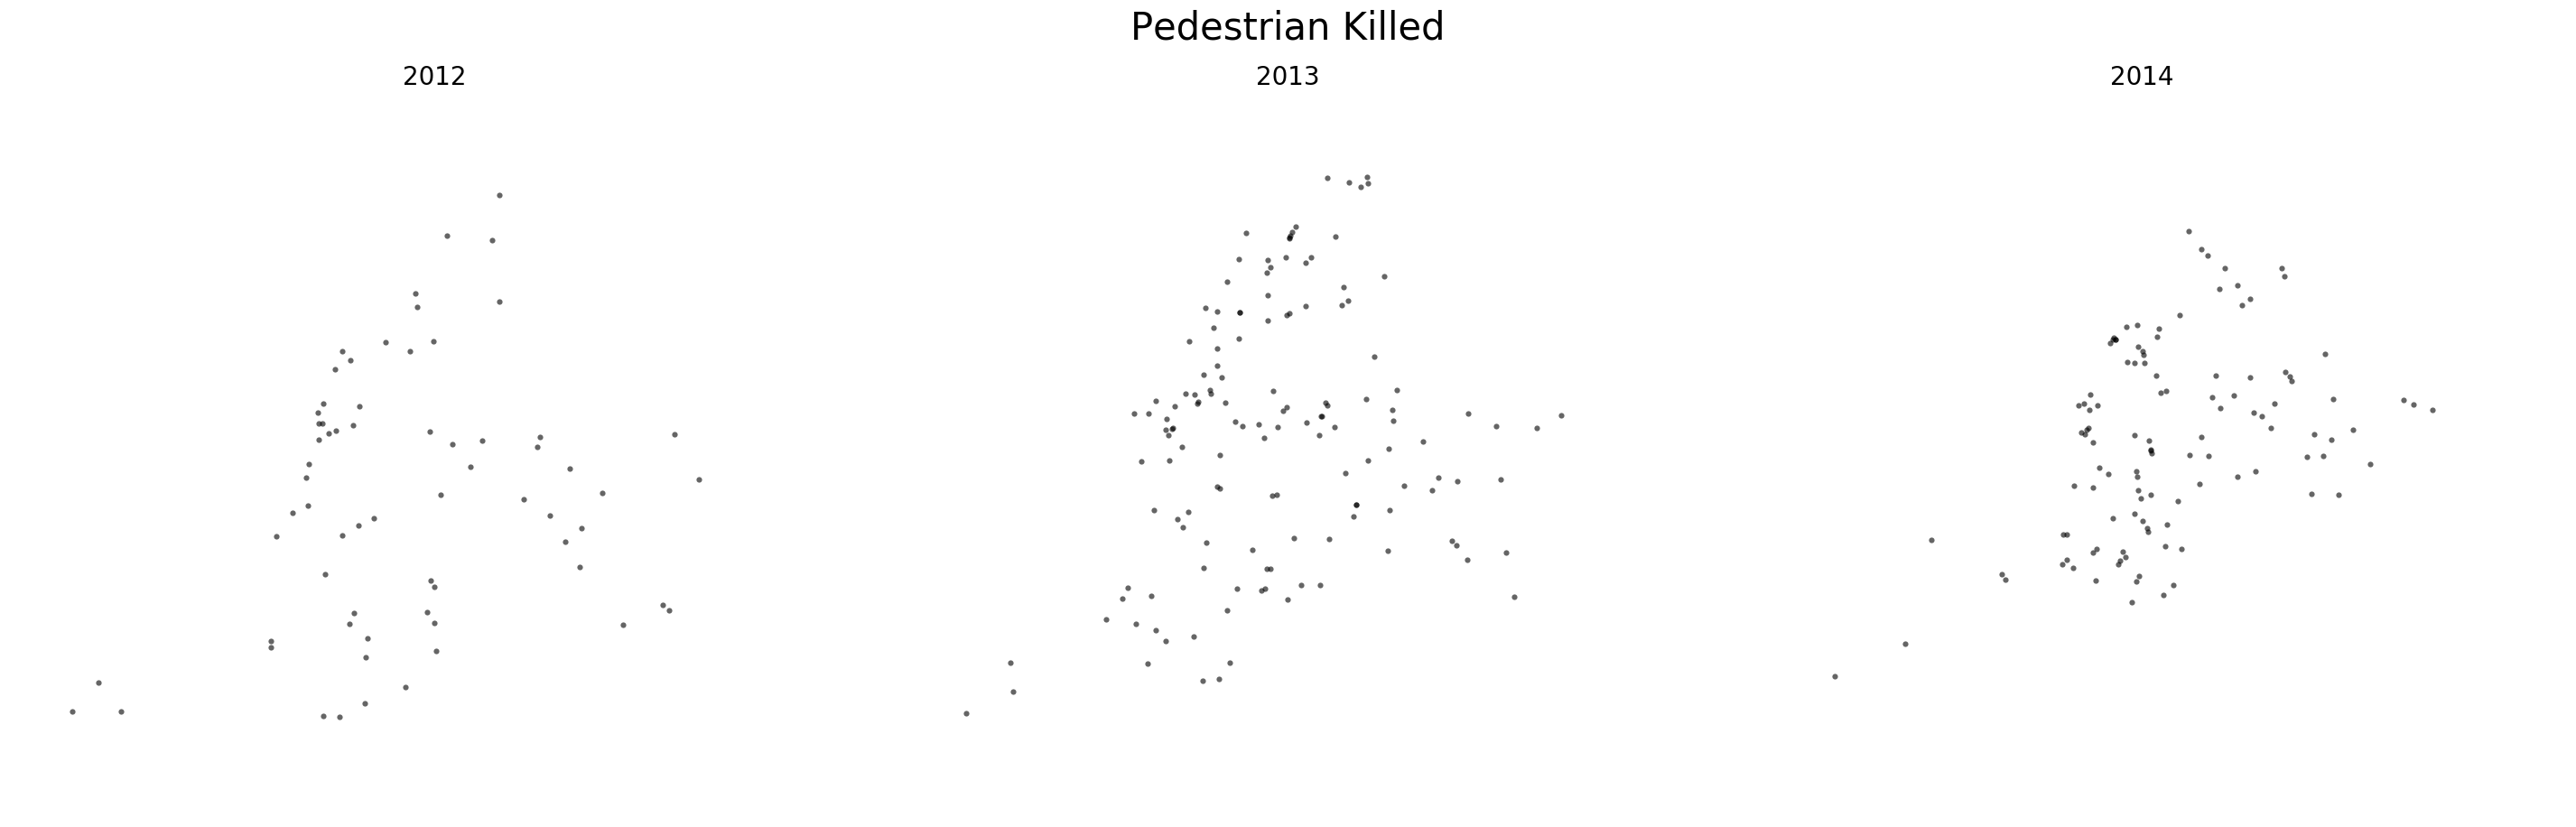

In [14]:
plotYearly(ped_died, 'Pedestrian Killed',0.6)

In [15]:
cyc = nyc_coll[nyc_coll.cyclist_injured > 0]

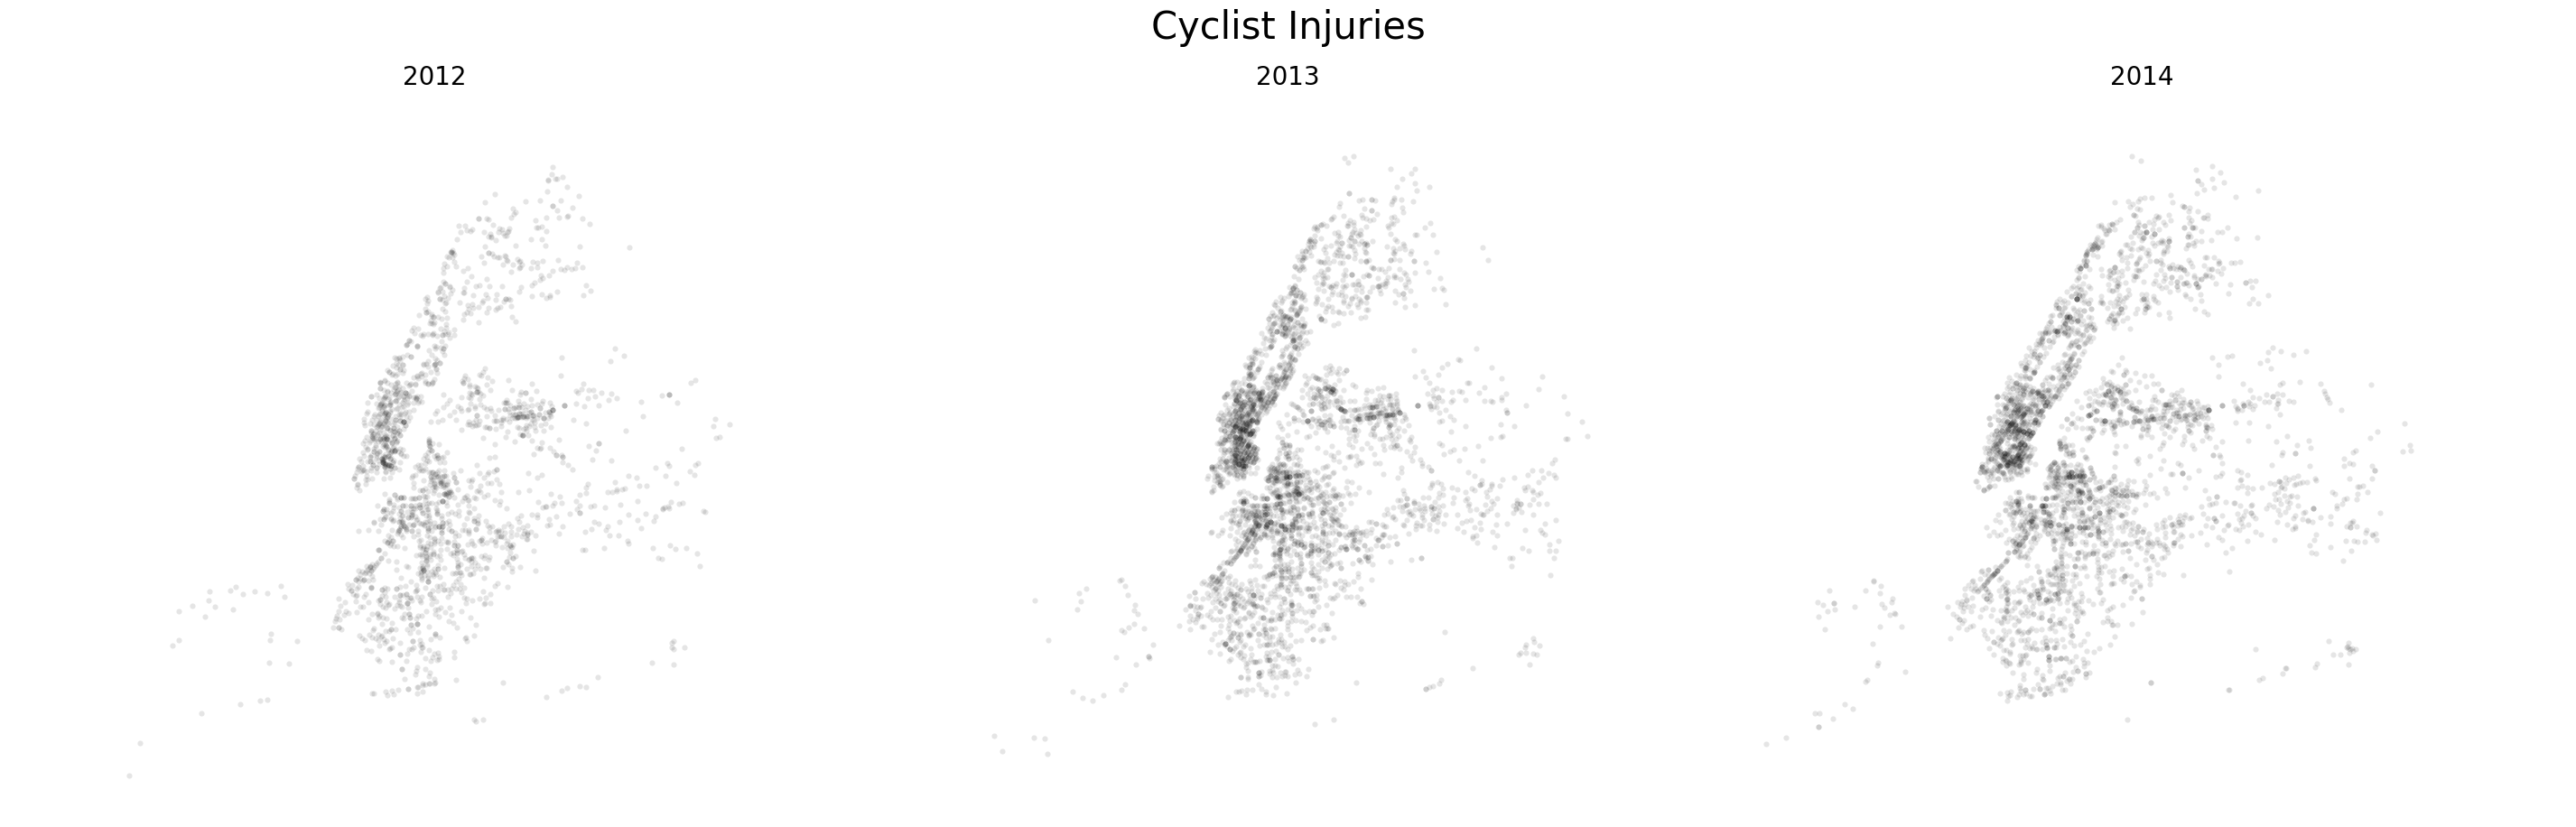

In [16]:
plotYearly(cyc, 'Cyclist Injuries', 0.1)

In [17]:
mot = nyc_coll[nyc_coll.motorist_injured > 0]

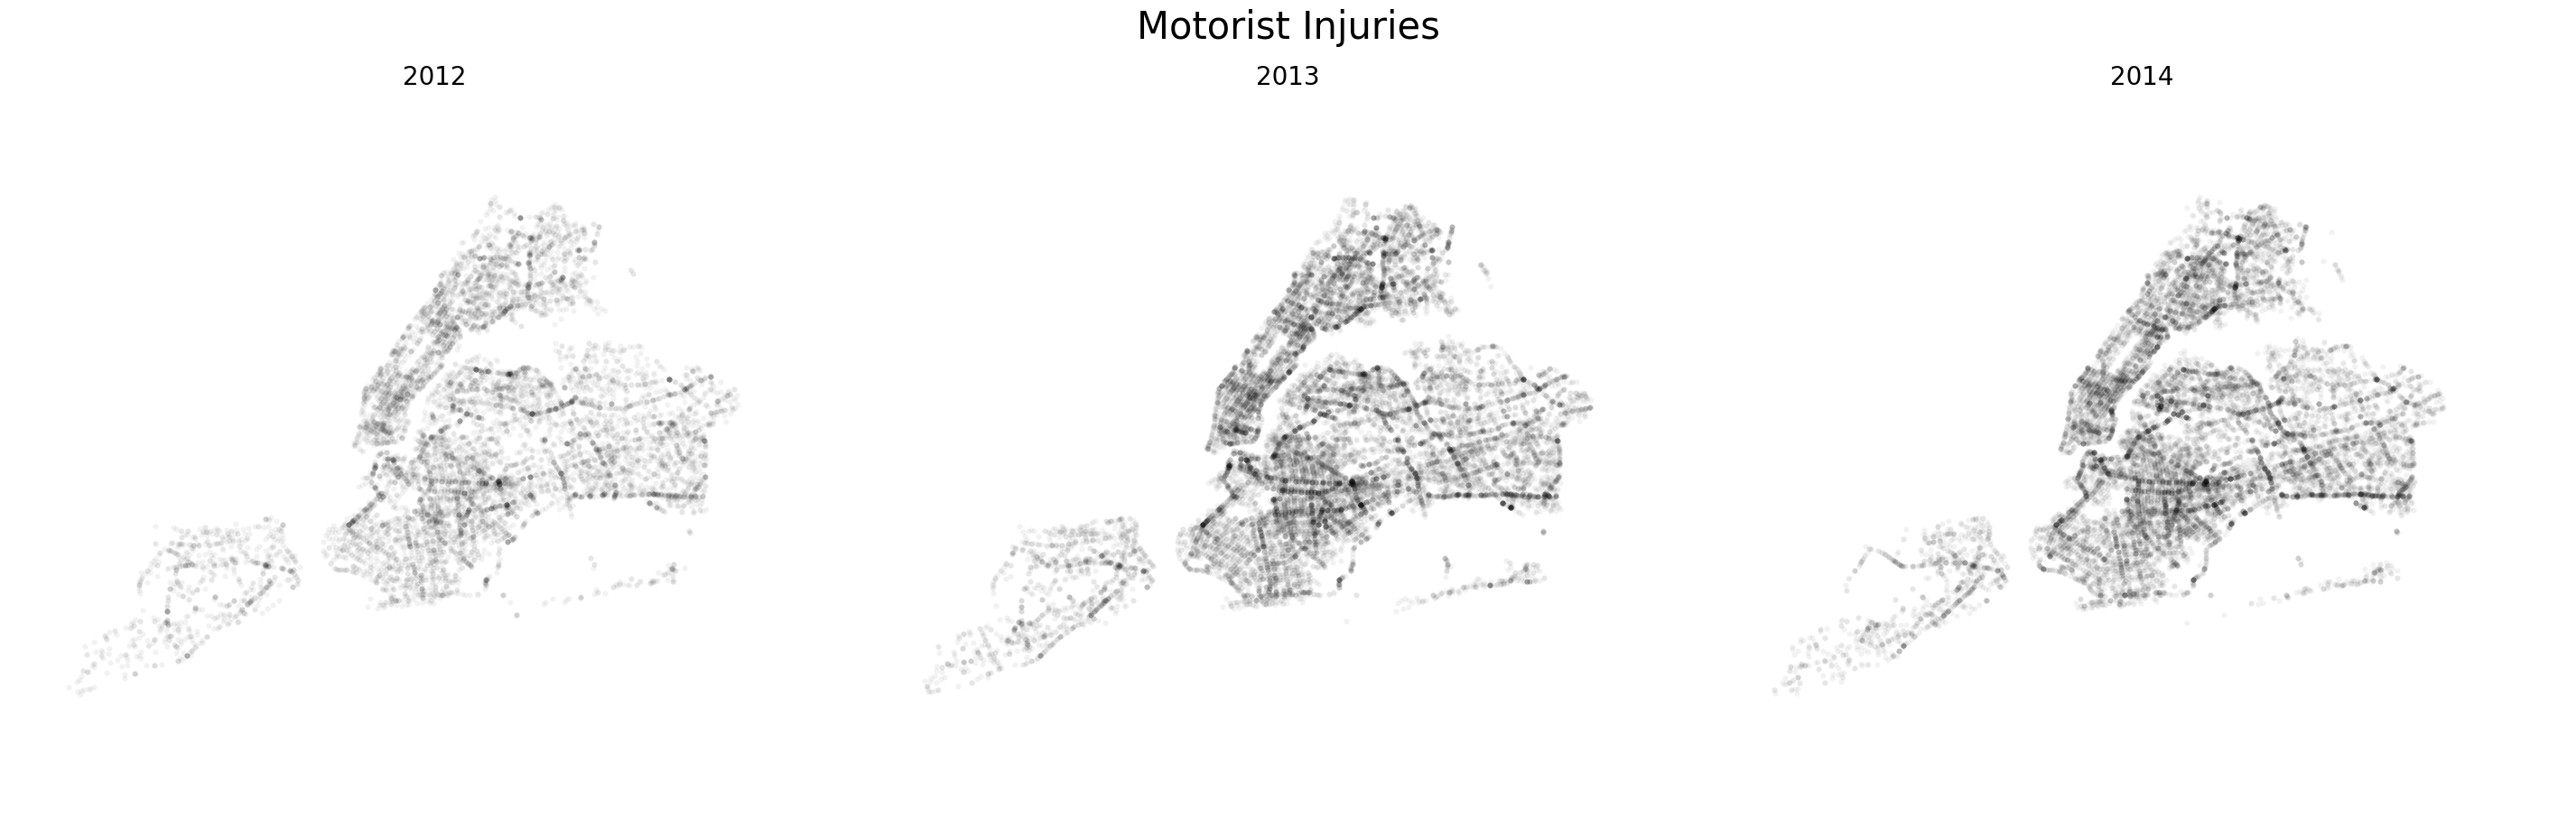

In [18]:
plotYearly(mot, 'Motorist Injuries', 0.05)

In [19]:
bus = nyc_coll[nyc_coll.vehicle == 'BUS']

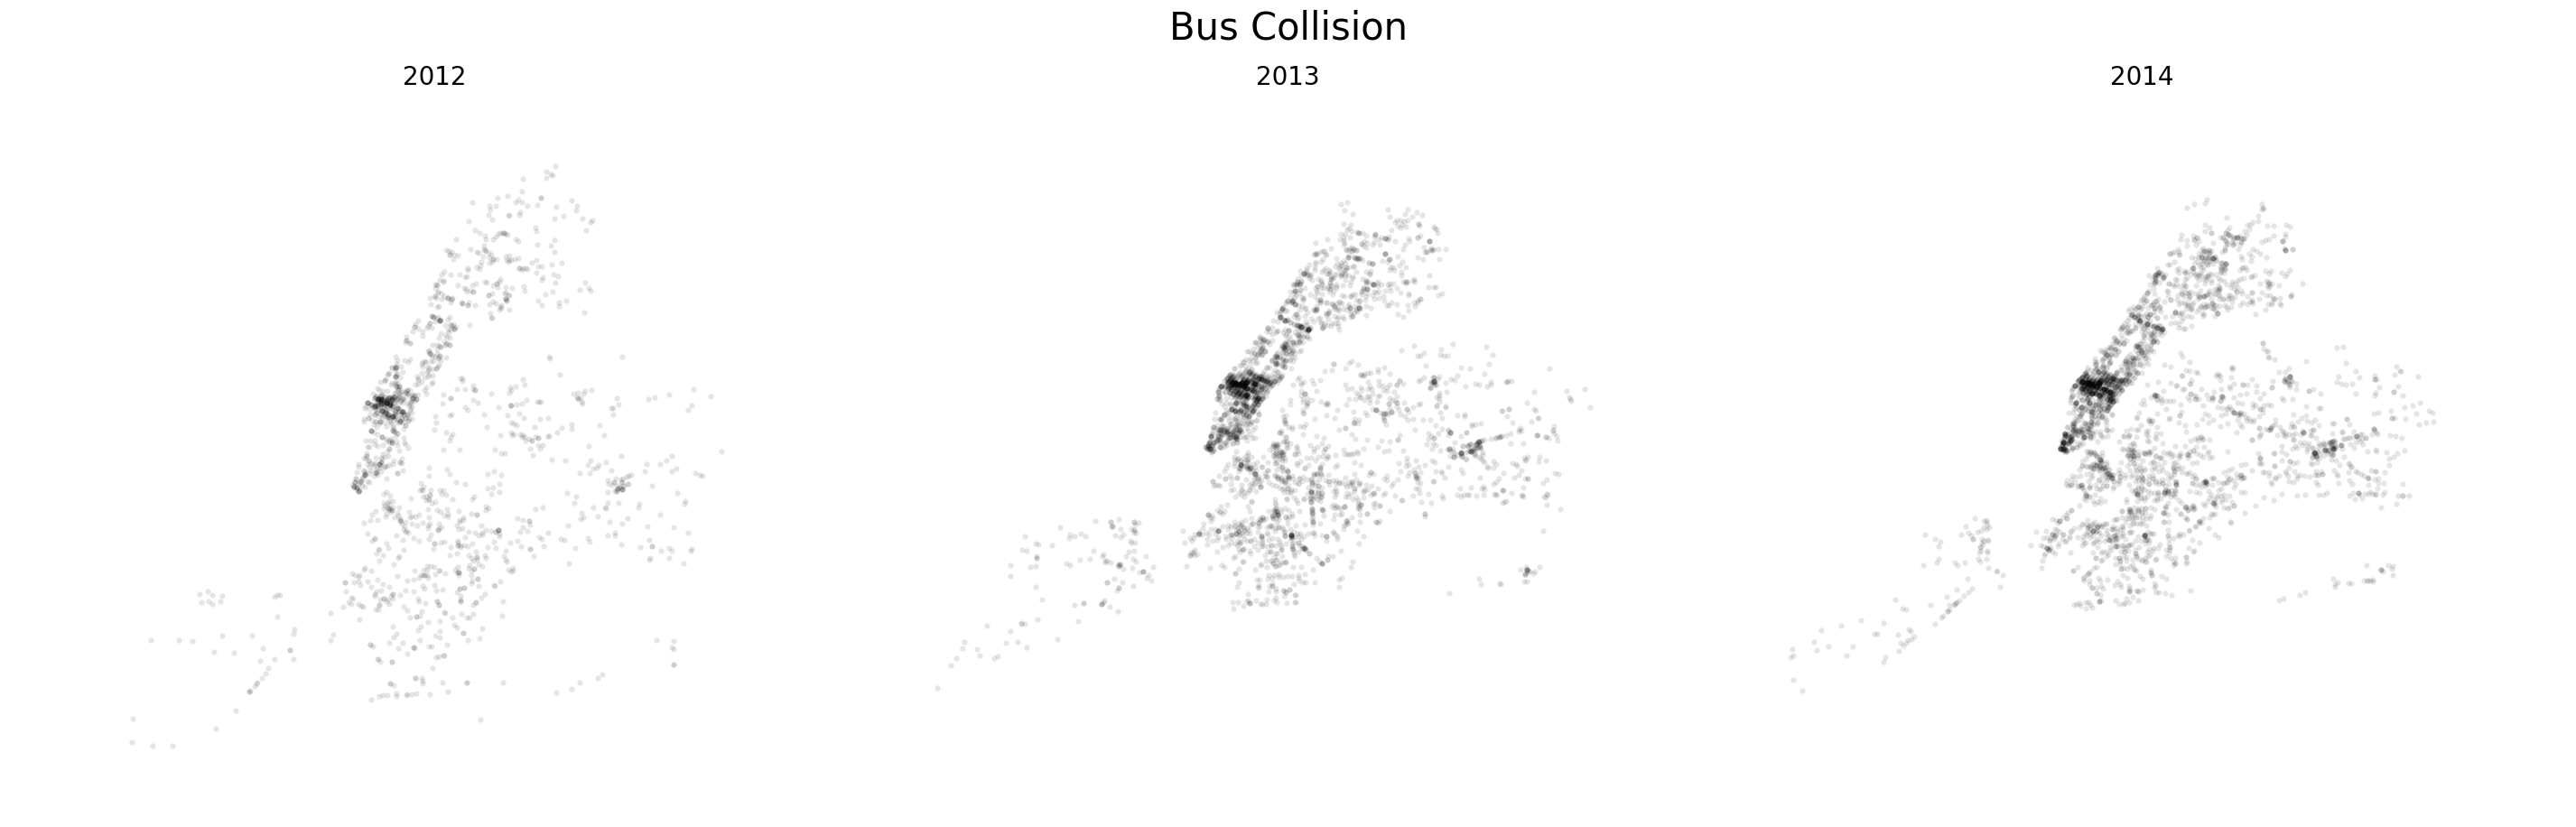

In [20]:
plotYearly(bus, 'Bus Collision', 0.1)

In [21]:
print 'Bus collision contributing factor:'
print bus.groupby('contributing_factor').count().iloc[:,0].sort_values(ascending=False).head()

Bus collision contributing factor:
contributing_factor
Unspecified                       4532
Driver Inattention/Distraction     932
Lost Consciousness                 314
Fatigued/Drowsy                    308
Other Vehicular                    302
Name: Unnamed: 0, dtype: int64


In [22]:
taxi = nyc_coll[nyc_coll.vehicle == 'TAXI']

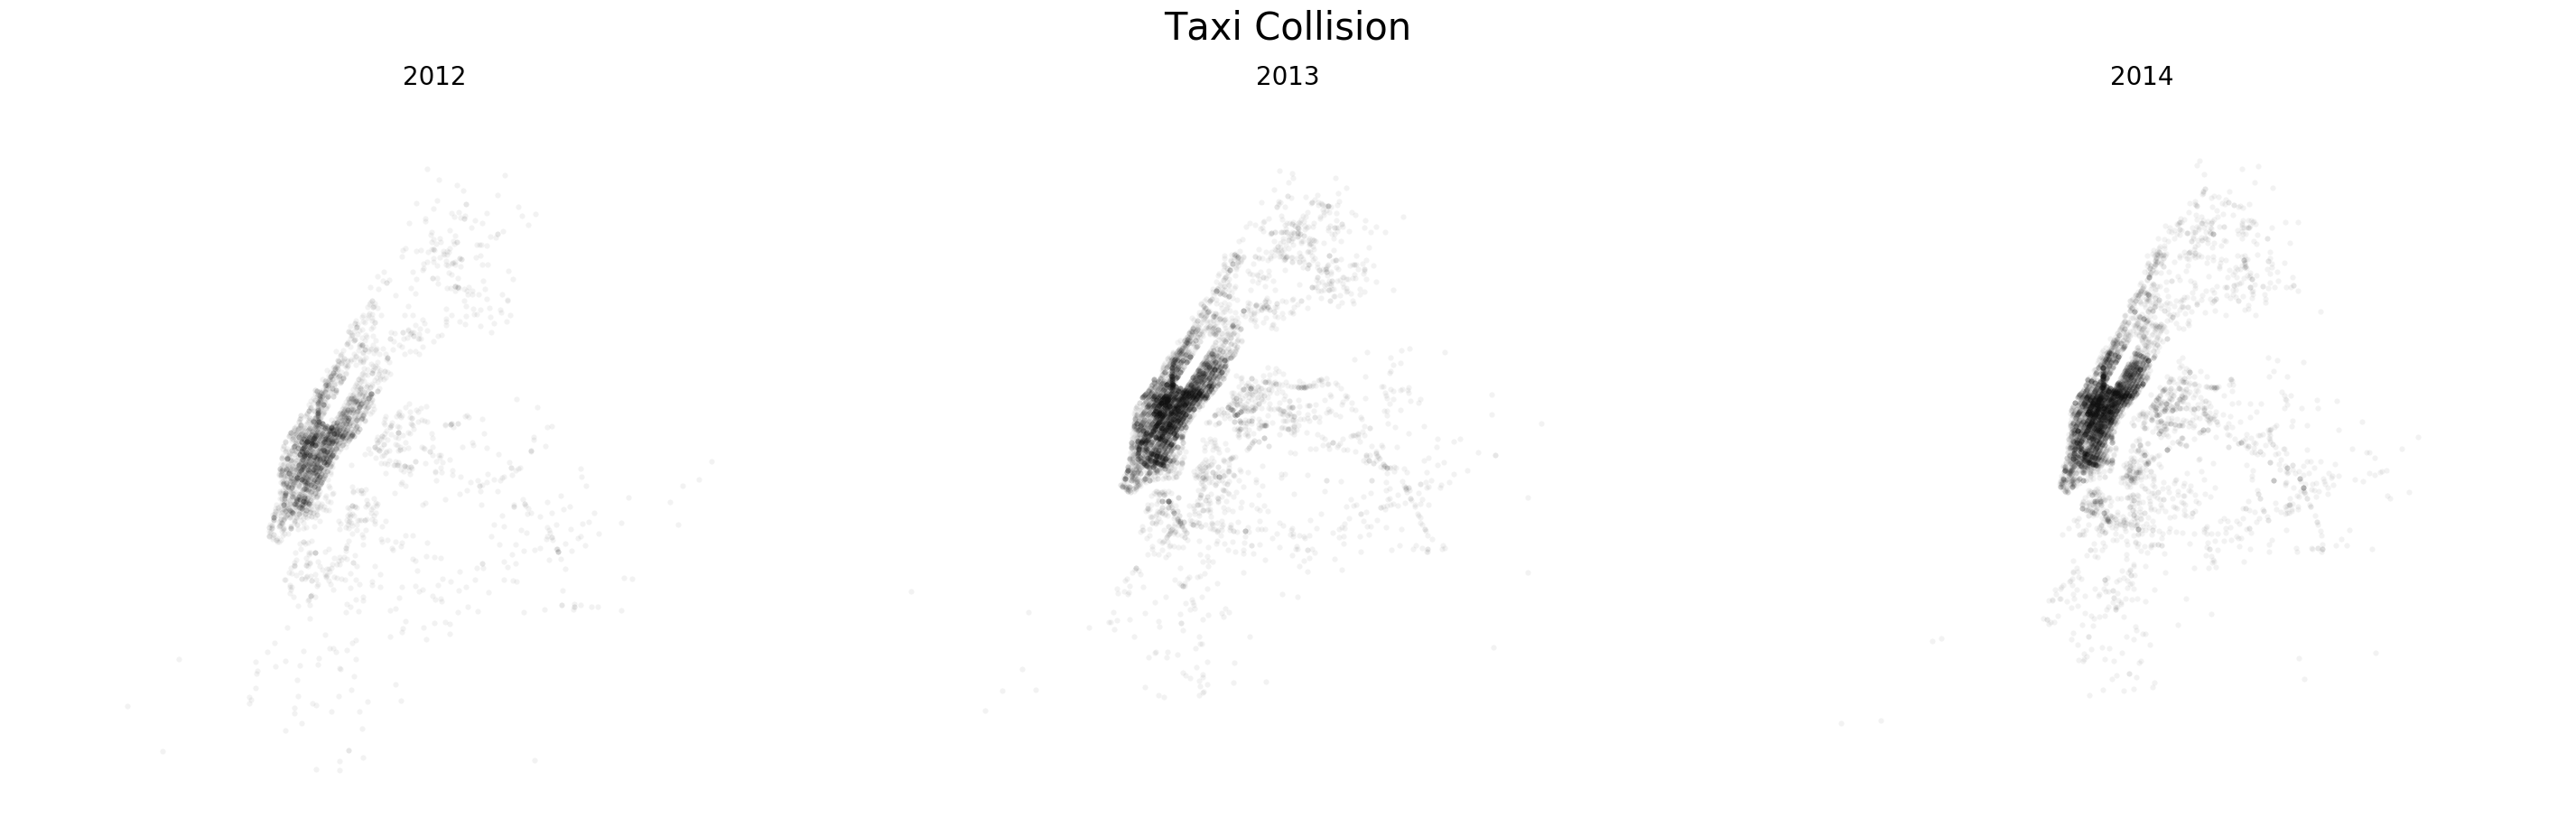

In [23]:
plotYearly(taxi, 'Taxi Collision', 0.05)

# Visualize data by category

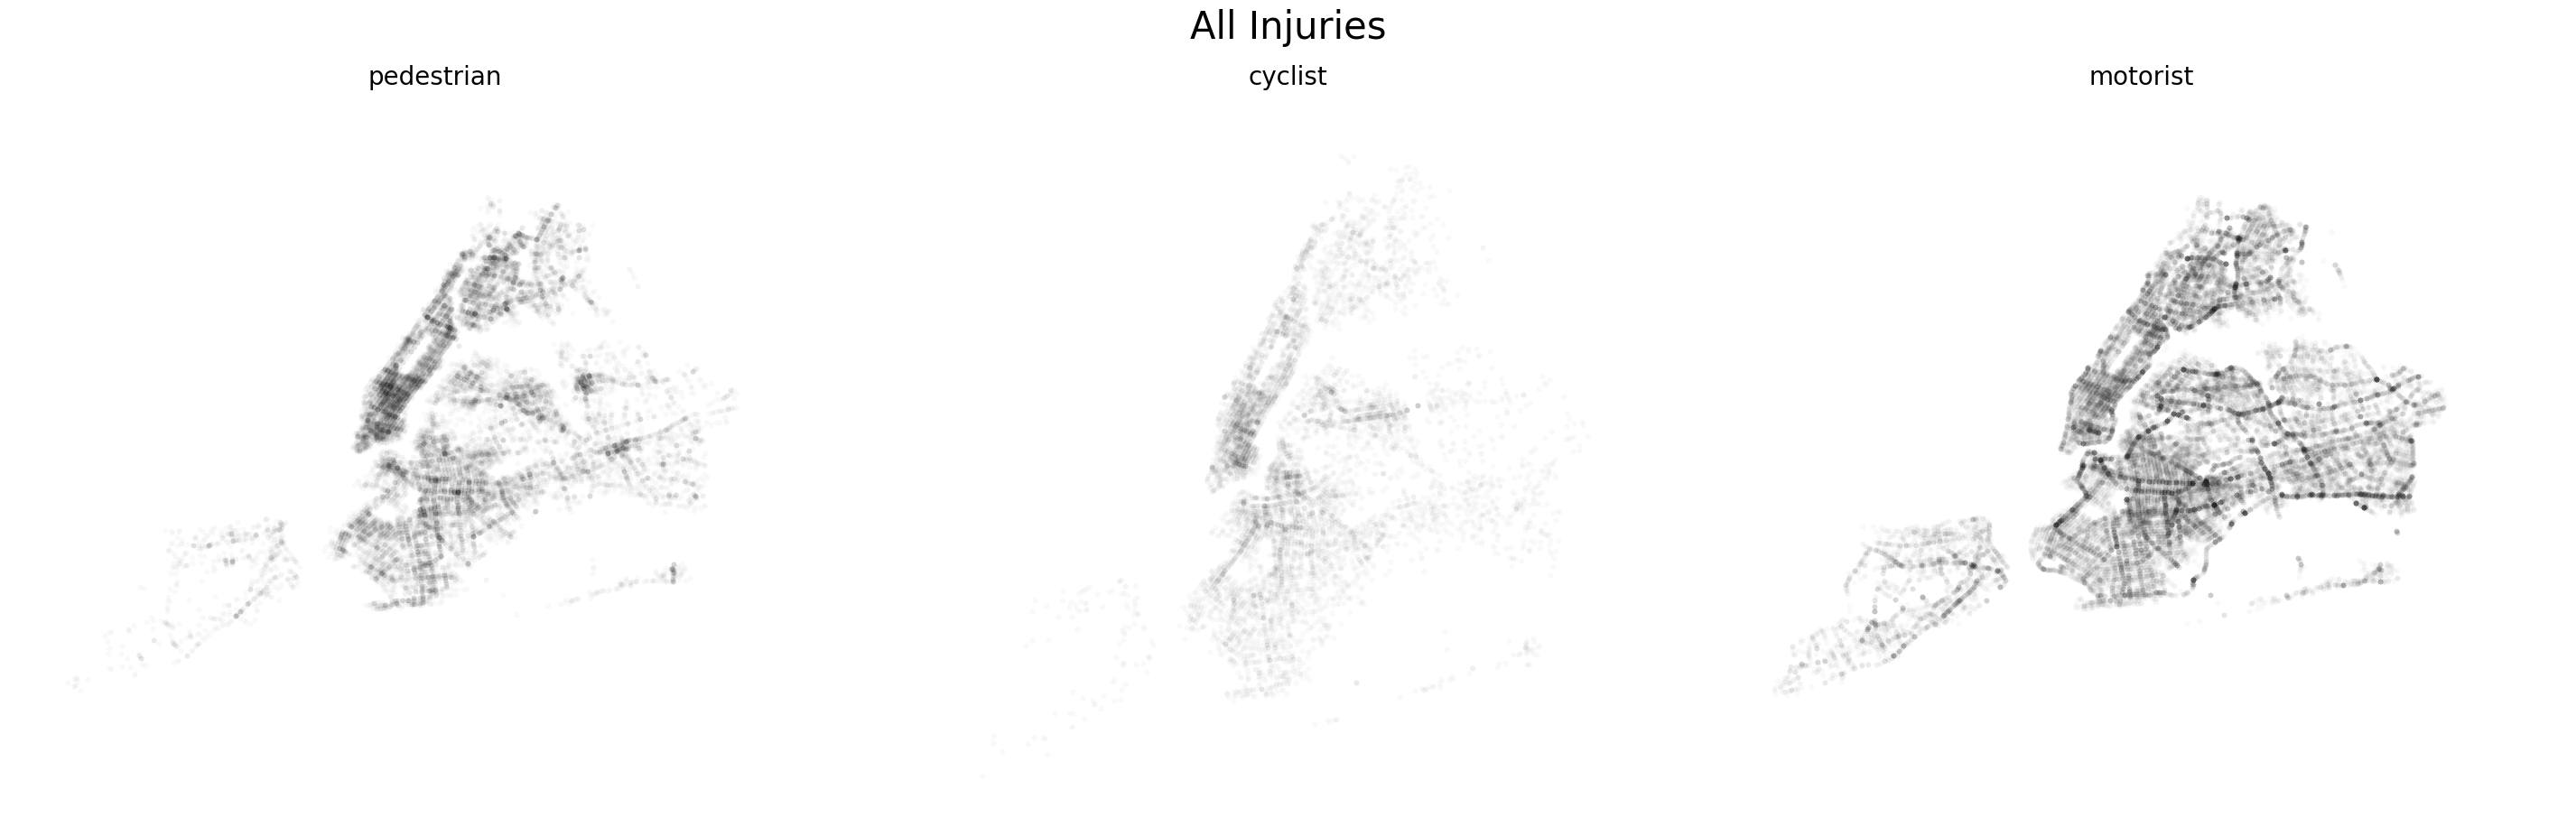

In [24]:
fig = plt.figure(figsize=(30,10))
plt.suptitle('All Injuries', fontsize=30)
dfs = [ped,cyc,mot]
titles = ['pedestrian', 'cyclist', 'motorist']
alphas = [0.025, 0.025, 0.025]
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    df = dfs[i]
    pts = np.array(df.loc[:,['long','lat']].astype(float))
    ax.scatter(pts[:,0],pts[:,1], lw=0, color='k',alpha=alphas[i])
    ax.set_title(titles[i], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=6)

In [25]:
passenger = nyc_coll[nyc_coll.vehicle == 'PASSENGER VEHICLE']

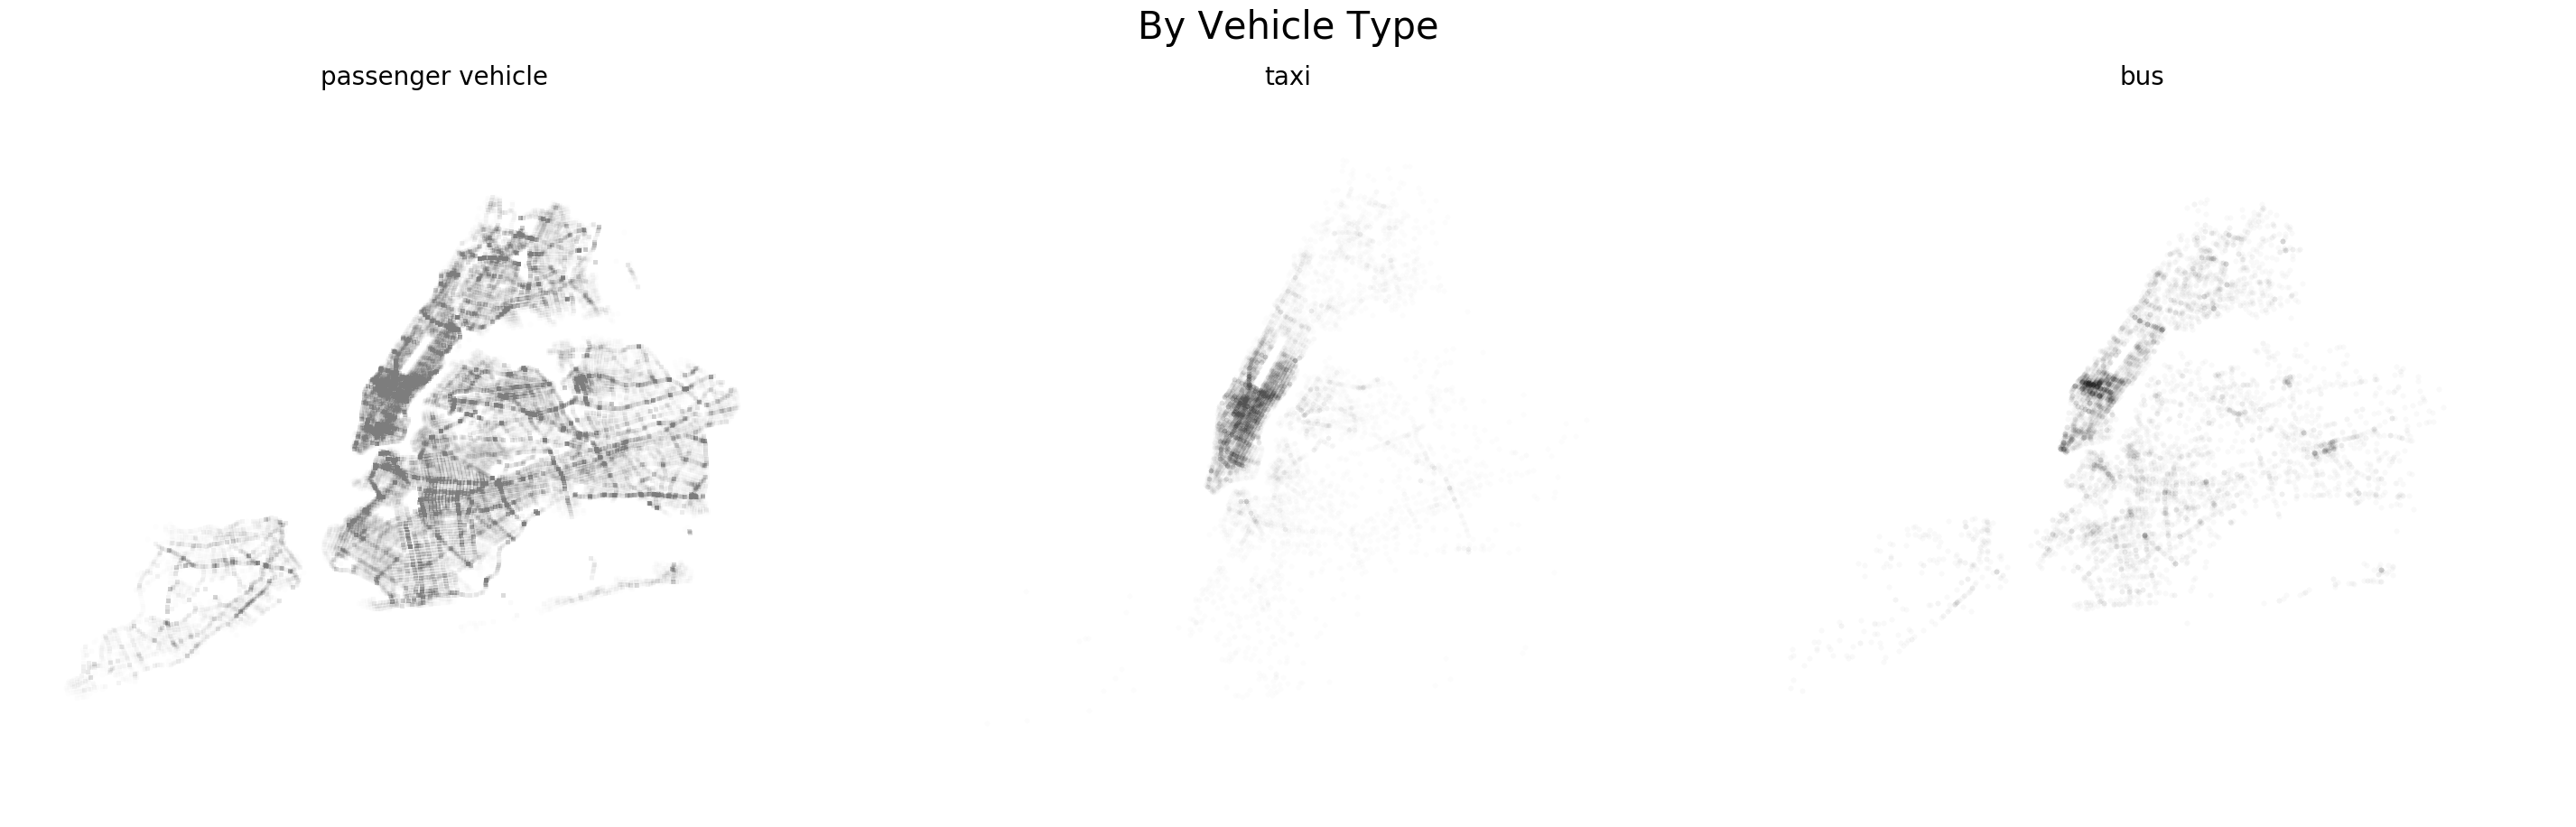

In [26]:
fig = plt.figure(figsize=(30,10))
plt.suptitle('By Vehicle Type', fontsize=30)
dfs = [passenger,taxi,bus]
titles = ['passenger vehicle', 'taxi', 'bus']
alphas = [0.008, 0.01, 0.025]
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    df = dfs[i]
    pts = np.array(df.loc[:,['long','lat']].astype(float))
    ax.scatter(pts[:,0],pts[:,1], lw=0, color='k',alpha=alphas[i])
    ax.set_title(titles[i], fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=6)

# Heatmap

In [27]:
min_y = nyc_coll['lat'].min()
max_y = nyc_coll['lat'].max()
rangelat = (max_y-min_y)/50
rangelat

0.0082775760000001249

In [28]:
min_x = nyc_coll['long'].min()
max_x = nyc_coll['long'].max()
rangelong = (max_x-min_x)/50
rangelong

0.011078695999999865

In [29]:
def showheatmap(dftest, numgrid, title):
    dftest = dftest
    pts = np.array(dftest.loc[:,['long','lat']].astype(float))
    x = pts[:,0]
    y = pts[:,1]

    gridx = np.linspace(min_x, max_x, numgrid)
    gridy = np.linspace(min_y, max_y, numgrid)

    grid, _, _ = np.histogram2d(y, x, bins=[gridy, gridx])
    
    digy = np.digitize(y, gridy)
    digx = np.digitize(x, gridx)

    plt.figure(figsize=(9,6))
    plt.pcolormesh(gridy, gridx, grid, cmap='coolwarm')
    plt.xlim(min_y,max_y)
    plt.ylim(min_x,max_x)
    plt.axis('off')
    plt.title(title)
    plt.colorbar()
    plt.show()
    return grid, digy, digx

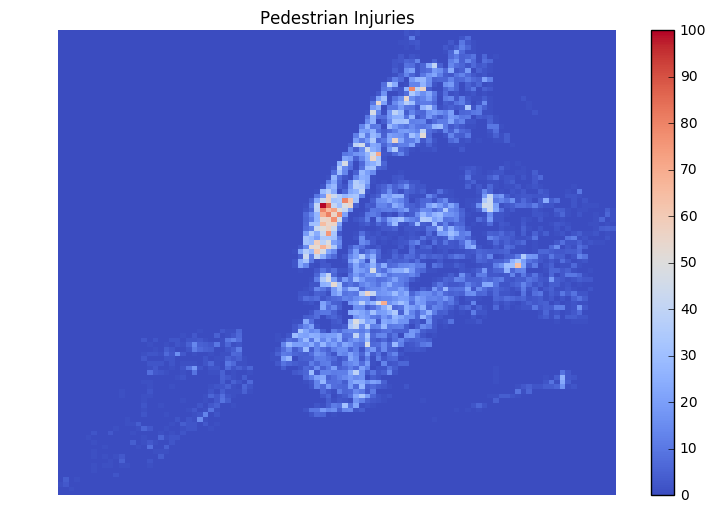

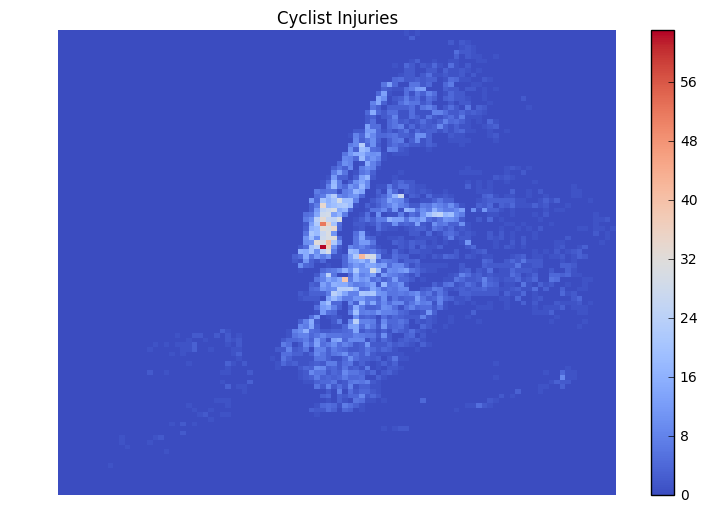

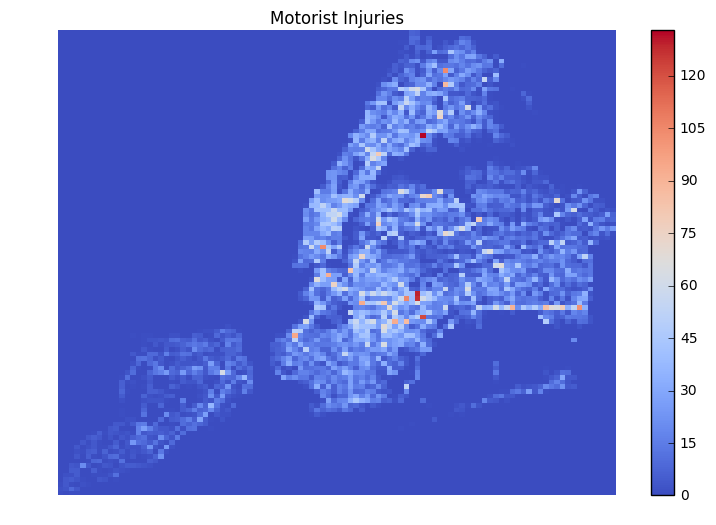

In [30]:
n_grid = 101
ped_grid_100 = showheatmap(ped,n_grid,'Pedestrian Injuries')
cyc_grid_100 = showheatmap(cyc,n_grid,'Cyclist Injuries')
mot_grid_100 = showheatmap(mot,n_grid,'Motorist Injuries')

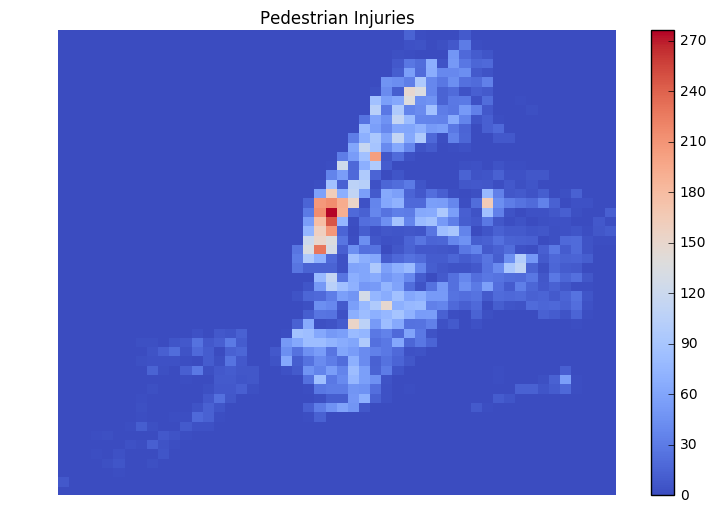

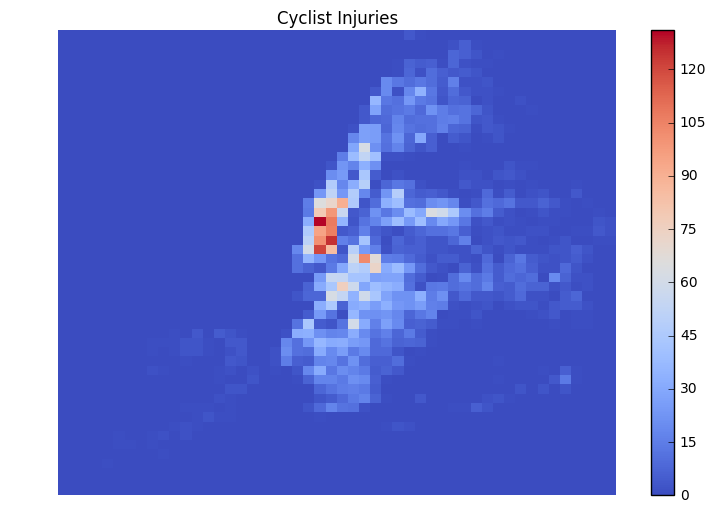

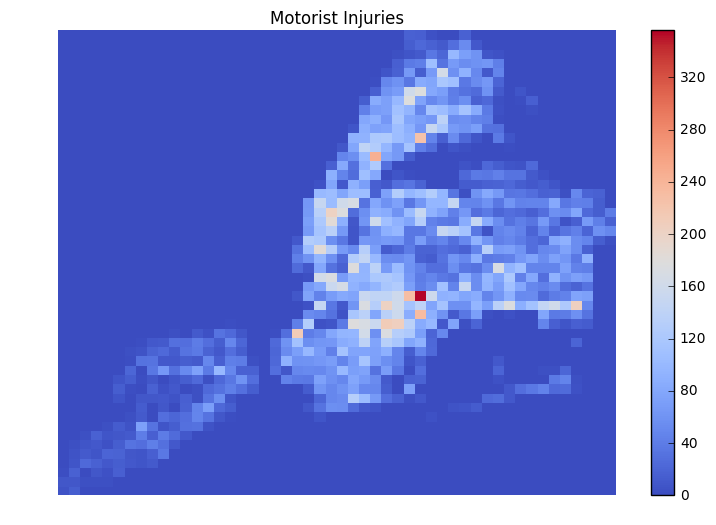

(array([[  6.,  15.,   0., ...,   0.,   0.,   0.],
        [  9.,   9.,   4., ...,   0.,   0.,   0.],
        [  2.,  17.,   0., ...,   0.,   0.,   0.],
        ..., 
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 7, 24, 12, ..., 40, 26, 26], dtype=int64),
 array([10, 42, 23, ..., 38, 28, 28], dtype=int64))

In [33]:
n_grid = 51
showheatmap(ped,n_grid,'Pedestrian Injuries')
showheatmap(cyc,n_grid,'Cyclist Injuries')
showheatmap(mot,n_grid,'Motorist Injuries')

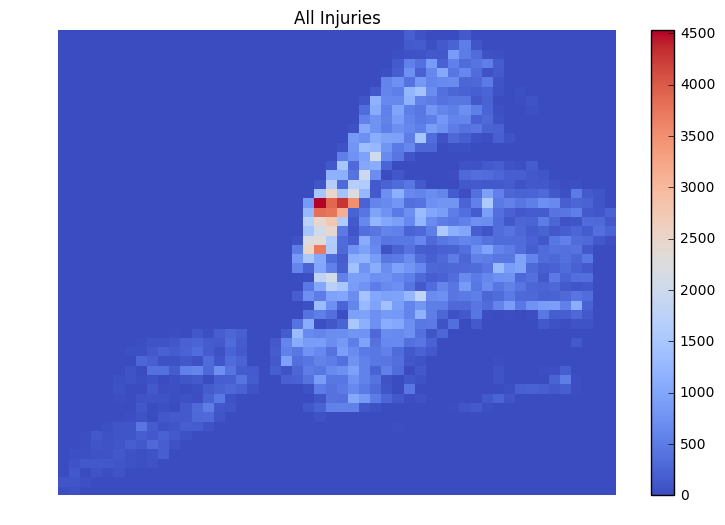

In [34]:
all_injuries = showheatmap(nyc_coll,51,'All Injuries')

In [35]:
#basemap
basemap = all_injuries.copy()
basemap[basemap == 0] = -1
basemap[basemap > 0] = 0
basemap

AttributeError: 'tuple' object has no attribute 'copy'

In [36]:
def getbest50(df):
    monthly_injuries = pd.DataFrame()
    months = sort(df['yearmonth'].unique())
    for i in months:
        dftest = df[df['yearmonth']==i]
        pts = np.array(dftest.loc[:,['long','lat']].astype(float))
        x = pts[:,0]
        y = pts[:,1]

        gridx = np.linspace(min_x, max_x, 51)
        gridy = np.linspace(min_y, max_y, 51)

        grid, _, _ = np.histogram2d(y, x, bins=[gridy, gridx])

        col_data=grid.flatten()
        monthly_injuries[i] = col_data
        
    selected = monthly_injuries.loc[:,'201207':'201412']
    best50 = selected.sum(axis=1).sort_values(ascending=False).head(50)
    best50df = selected.ix[best50.index]
    best50_2016 = monthly_injuries.sum(axis=1).sort_values(ascending=False).head(50)
    return best50df, best50_2016

In [37]:
ped_monthly, ped_trend_2016 = getbest50(ped)
ped_monthly.to_csv('ped_monthly.csv')
ped_trend_2016.to_csv('ped_trend.csv')

In [38]:
cyc_monthly, cyc_trend_2016 = getbest50(cyc)
cyc_monthly.to_csv('cyc_monthly.csv')
cyc_trend_2016.to_csv('cyc_trend.csv')

In [39]:
mot_monthly, mot_trend_2016 = getbest50(mot)
mot_monthly.to_csv('mot_monthly.csv')
mot_trend_2016.to_csv('mot_trend.csv')

In [40]:
a = motgrid50_2014
i,j = np.unravel_index(a.argmax(), a.shape)
i,j

NameError: name 'motgrid50_2014' is not defined

In [41]:
gridx = np.linspace(min_x, max_x, 51)
gridy = np.linspace(min_y, max_y, 51)

In [42]:
gridx[j],gridx[j+1]

NameError: name 'j' is not defined

In [43]:
gridy[i],gridy[i+1]

(40.515503951999996, 40.523781527999994)

## Start focusing on pedestrian

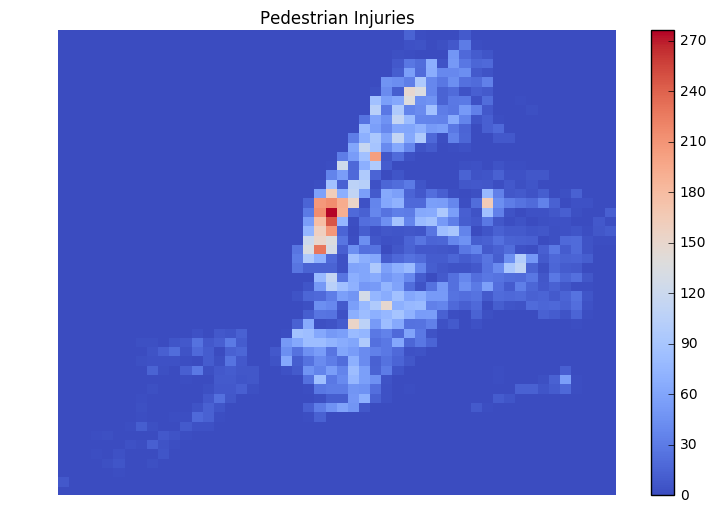

In [44]:
pedgrid = showheatmap(ped,n_grid,'Pedestrian Injuries')

In [45]:
taxi_ped = taxi[taxi.pedestrian_injured>0]

In [46]:
others_ped = ped[ped['vehicle'].isin(['OTHER','VAN','PICK-UP TRUCK'])]
commercial_ped = ped[ped['vehicle'].isin(['LARGE COM VEH(6 OR MORE TIRES)',
                                          'LIVERY VEHICLE',
                                          'SMALL COM VEH(4 TIRES)'])]
non_car_passenger_ped = ped[ped['vehicle'].isin(['BICYCLE'])]
motorcycle_ped = ped[ped['vehicle'].isin(['MOTORCYCLE','SCOOTER'])]
passenger_ped = ped[ped['vehicle'].isin(['PASSENGER VEHICLE',
                                         'SPORT UTILITY / STATION WAGON'])]
ambulance_ped = ped[ped['vehicle'].isin(['AMBULANCE'])]
bus_ped = ped[ped['vehicle'].isin(['BUS'])]
fire_truck_ped = ped[ped['vehicle'].isin(['FIRE TRUCK'])]

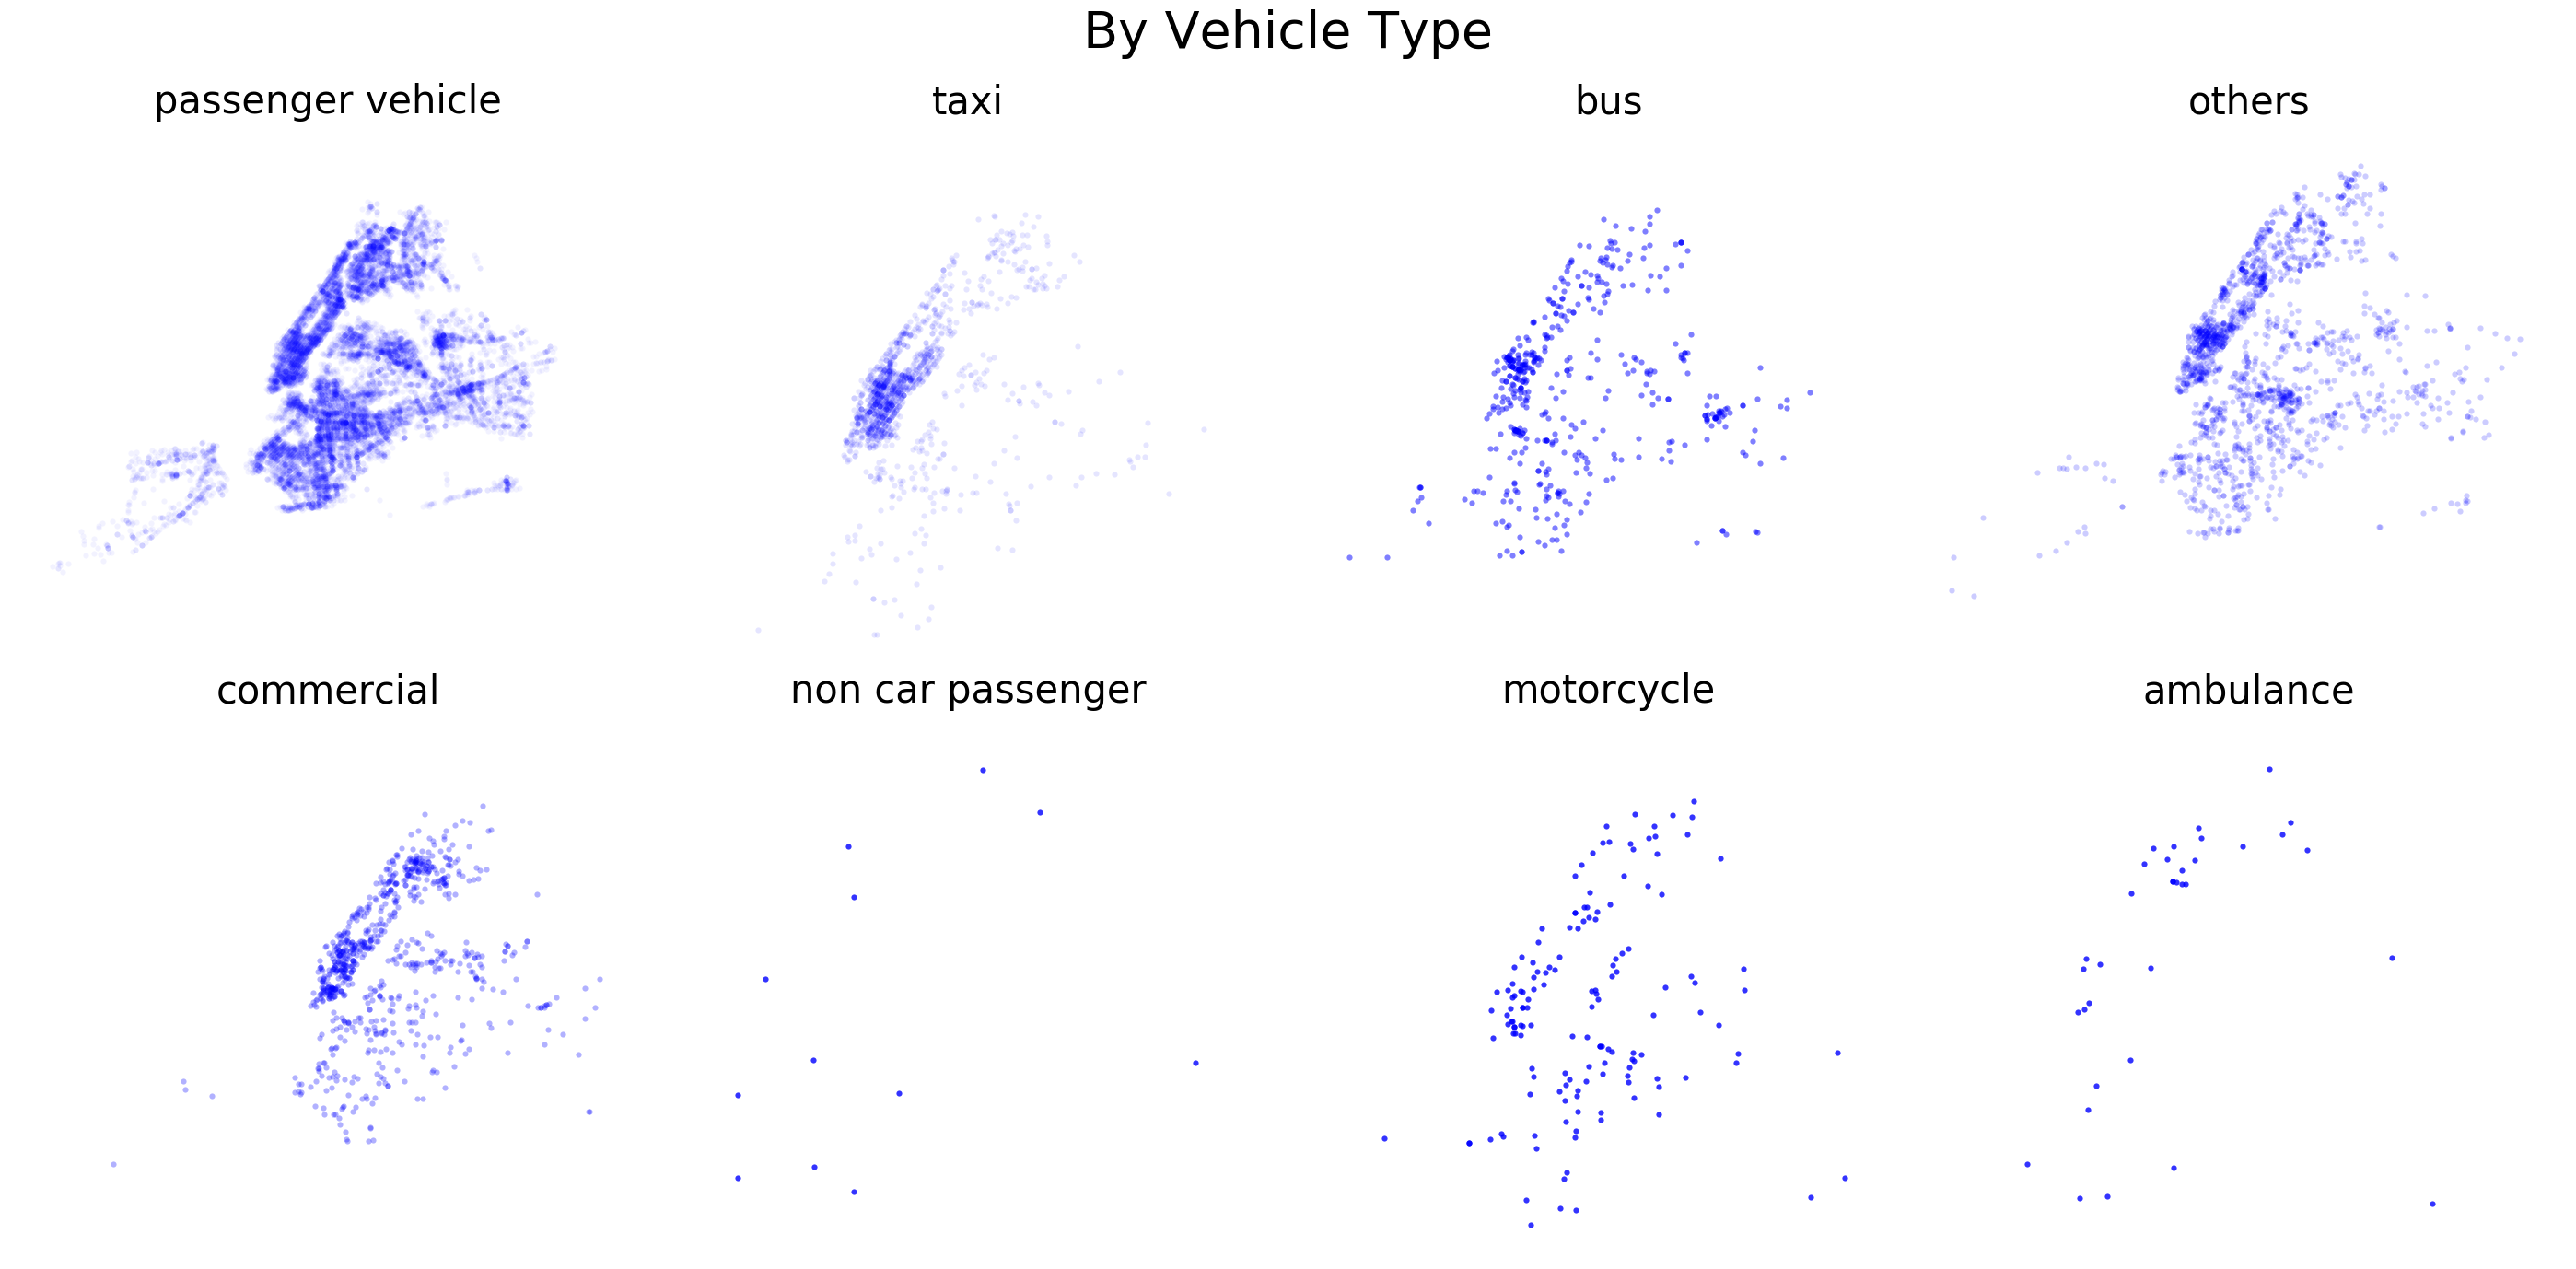

In [67]:
fig = plt.figure(figsize=(30,15))
plt.suptitle('By Vehicle Type', fontsize=40)
dfs = [passenger_ped,taxi_ped,bus_ped,
      others_ped,commercial_ped,non_car_passenger_ped,
      motorcycle_ped,ambulance_ped]
titles = ['passenger vehicle', 'taxi', 'bus',
         'others','commercial','non car passenger',
         'motorcycle','ambulance']
alphas = [0.05, 0.1, 0.5,
         0.2,0.3,0.8,
         0.8,0.8]
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    df = dfs[i]
    pts = np.array(df.loc[:,['long','lat']].astype(float))
    ax.scatter(pts[:,0],pts[:,1], lw=0, color='b',alpha=alphas[i])
    ax.set_title(titles[i], fontsize=30)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.axis('equal')
plt.tight_layout(w_pad=0.2, h_pad=0.2, pad=8)

In [53]:
for i in range(len(dfs)):
    filename = titles[i] + '.csv'
    dfs[i].to_csv(filename)

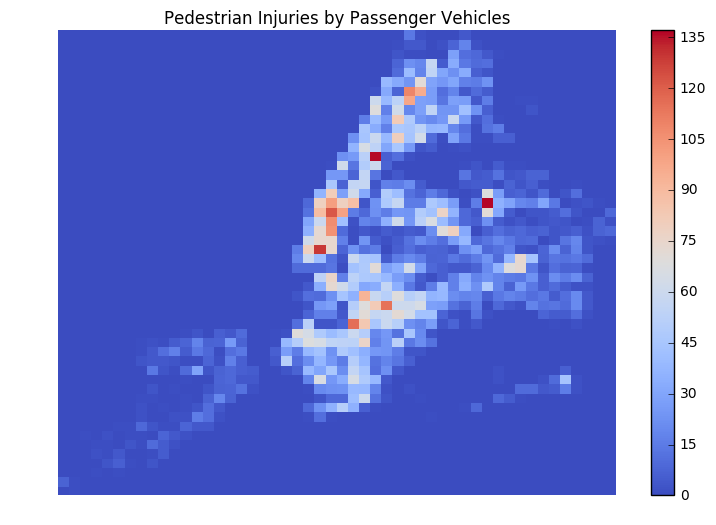

In [47]:
pass_inj = showheatmap(passenger_ped,51,'Pedestrian Injuries by Passenger Vehicles')

In [398]:
np.where(pass_inj>120)

(array([26, 30, 31, 36], dtype=int64), array([23, 24, 38, 28], dtype=int64))

In [187]:
pass_inj[12,26]

65.0

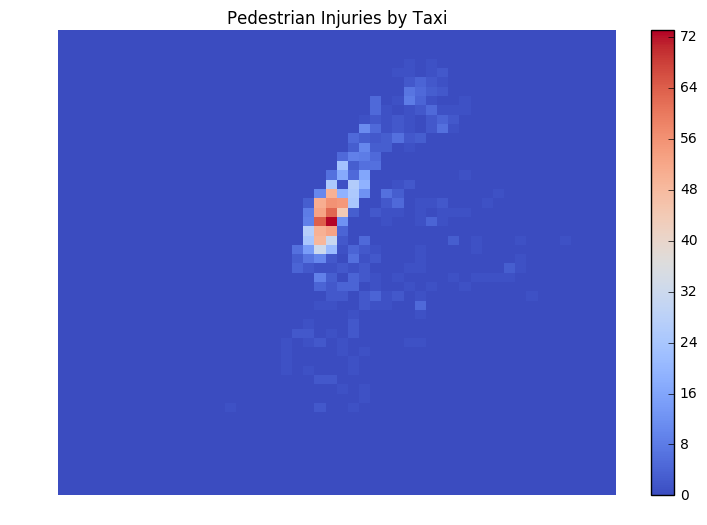

In [48]:
taxi_inj = showheatmap(taxi_ped,51,'Pedestrian Injuries by Taxi')

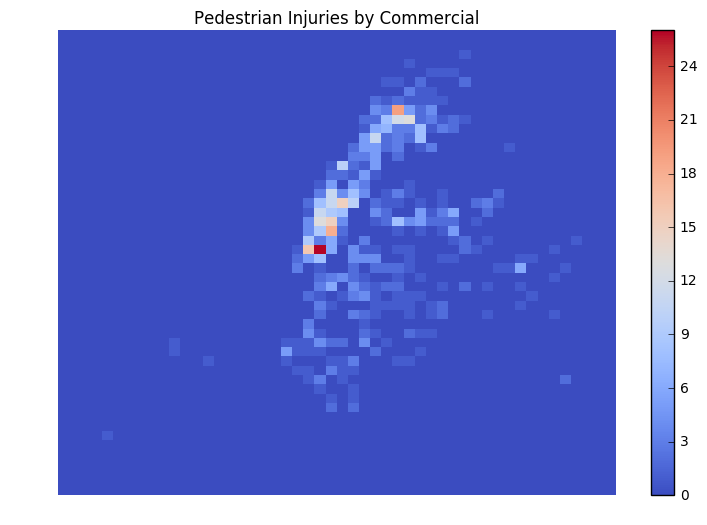

In [49]:
comm_inj = showheatmap(commercial_ped,51,'Pedestrian Injuries by Commercial')

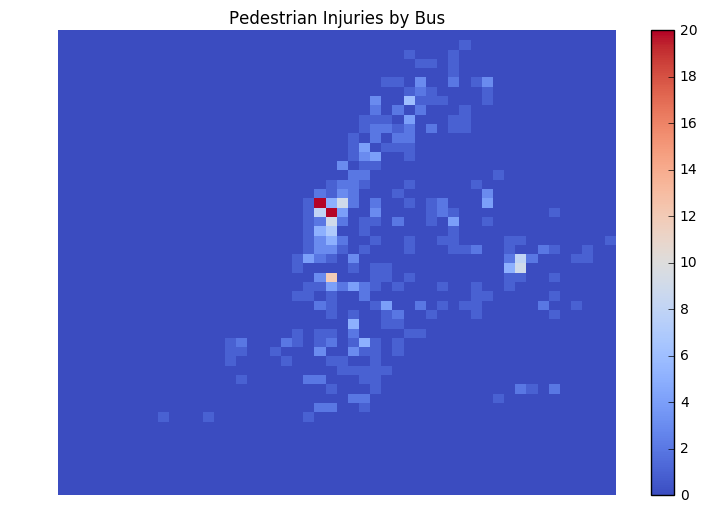

In [50]:
bus_inj = showheatmap(bus_ped,51,'Pedestrian Injuries by Bus')

In [168]:
np.where(bus_inj>8)

(array([23, 24, 29, 30, 31, 31], dtype=int64),
 array([24, 41, 24, 24, 23, 25], dtype=int64))

## Start including passenger

In [75]:
all_passenger = pd.read_csv('pedestrian_data2.csv')

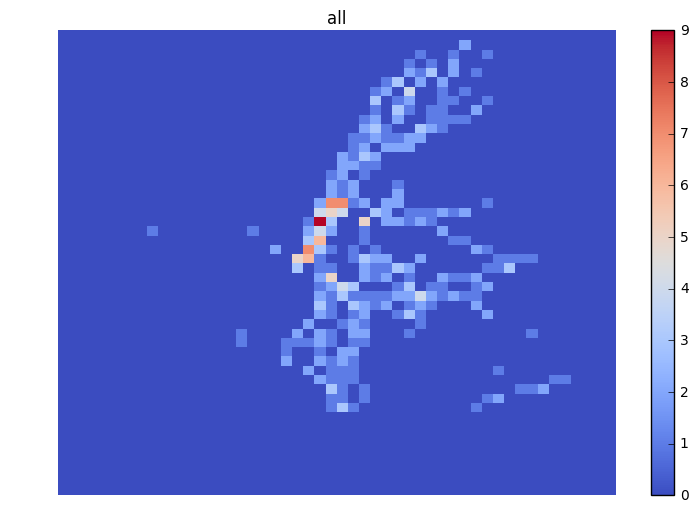

In [76]:
passgrid, digy, digx = showheatmap(all_passenger,51,'all')

In [77]:
all_passenger['digx']=digy
all_passenger['digy']=digx

In [78]:
passenger_by_grid = all_passenger.groupby(['digx','digy']).sum().reset_index()
passenger_by_grid = passenger_by_grid.rename(columns={'0':'passenger'})

In [79]:
passenger_array = np.zeros((50,50))
for i in passenger_by_grid.index:
    x = passenger_by_grid.ix[i]['digx']
    y = passenger_by_grid.ix[i]['digy']
    passenger_array[x,y] = passenger_by_grid.ix[i]['passenger']

C:\Users\Nurvirta\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


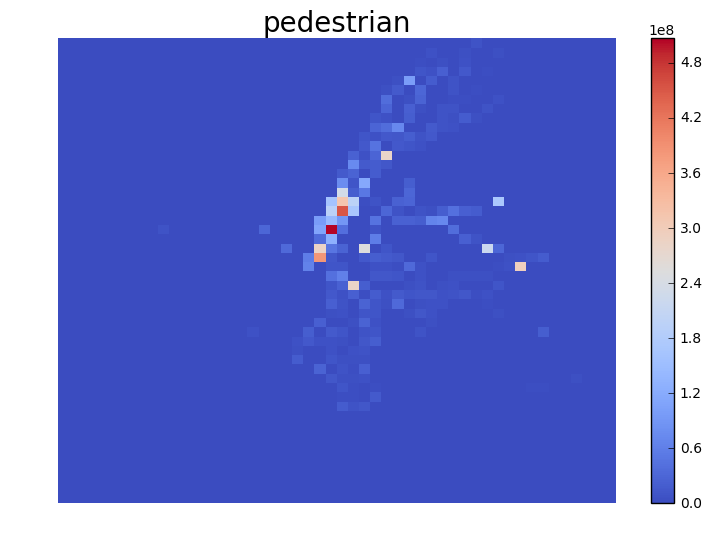

In [80]:
numgrid = 51
gridx = np.linspace(min_x, max_x, numgrid)
gridy = np.linspace(min_y, max_y, numgrid)

plt.figure(figsize=(9,6))
plt.pcolormesh(gridy, gridx, passenger_array, cmap='coolwarm')
plt.xlim(min_y,max_y)
plt.ylim(min_x,max_x)
plt.axis('off')
plt.title('pedestrian', fontsize=20)
plt.colorbar()
plt.show()

In [81]:
passenger_array[12,26]

1996262.0

In [82]:
passenger_array[(passenger_array<2.4*1e8)&\
               (passenger_array>1.8*1e8)]

array([  2.19046553e+08,   1.95601304e+08,   1.96987184e+08,
         2.32875342e+08])

In [159]:
np.where(passenger_array>1.8*1e8)

(array([23, 25, 26, 27, 27, 27, 29, 31, 31, 32, 32, 33, 37], dtype=int64),
 array([26, 41, 23, 23, 27, 38, 24, 24, 25, 25, 26, 25, 29], dtype=int64))

In [339]:
temp=passenger_array[36,28]
passenger_array[36,28]=passenger_array[37,29]
passenger_array[37,29]=temp

In [292]:
passenger_array[31,38] = passenger_array[32,39]

In [293]:
passenger_array[32,29] = 0

In [294]:
passenger_array[24,41] = passenger_array[25,41]
passenger_array[25,41] = 0

In [300]:
passenger_array[31,23] = 0.3*passenger_array[31,24]

In [55]:
pass_inj.shape

(50L, 50L)

In [310]:
def getNormalizedInjuries(injuries_array, passenger_array):
    normalized = np.zeros((50,50))
    for i in range(50):
        for j in range(50):
            if passenger_array[i,j] == 0:
                continue
            else:
                normalized[i,j]=injuries_array[i,j]/passenger_array[i,j]
    return normalized

In [311]:
def showheatmap_bygrid(df, numgrid, title):
    gridx = np.linspace(min_x, max_x, numgrid)
    gridy = np.linspace(min_y, max_y, numgrid)

    plt.figure(figsize=(9,6))
    plt.pcolormesh(gridy, gridx, df, cmap='coolwarm')
    plt.xlim(min_y,max_y)
    plt.ylim(min_x,max_x)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.colorbar()
    plt.show()

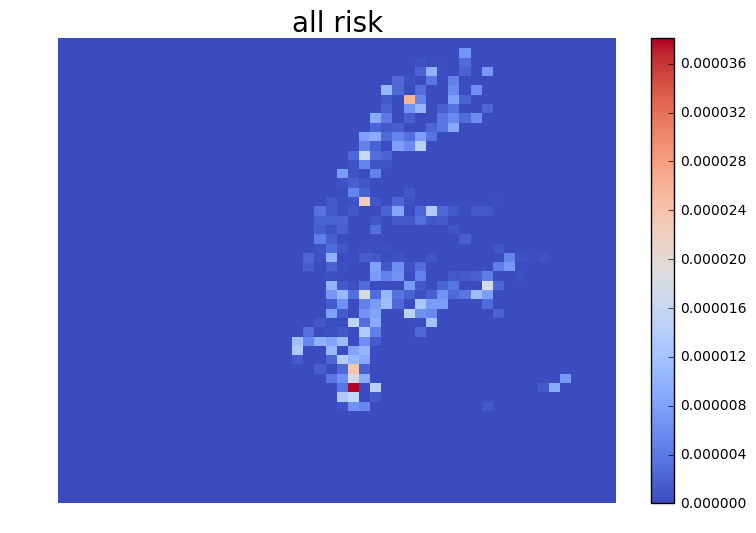

In [341]:
all_inj_normalized = getNormalizedInjuries(pedgrid[0], passenger_array)
showheatmap_bygrid(all_inj_normalized, 51, 'all risk')

In [361]:
all_inj_normalized[36,28]

7.2538356987847373e-07

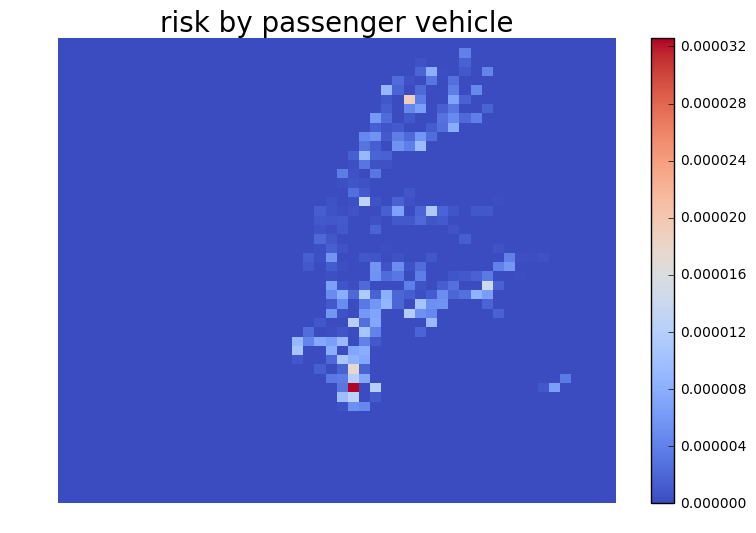

In [342]:
pass_inj_normalized = getNormalizedInjuries(pass_inj, passenger_array)
showheatmap_bygrid(pass_inj_normalized, 51, 'risk by passenger vehicle')

In [313]:
maxpass = pass_inj_normalized.max()
np.where(pass_inj_normalized==maxpass)

(array([12], dtype=int64), array([26], dtype=int64))

In [362]:
pass_inj_normalized[12,26]

3.2560856240313142e-05

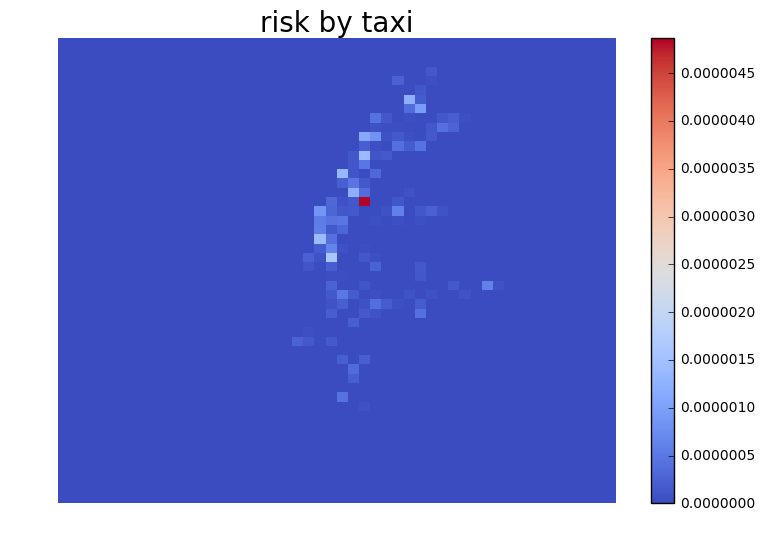

In [343]:
taxi_inj_normalized = getNormalizedInjuries(taxi_inj, passenger_array)
showheatmap_bygrid(taxi_inj_normalized, 51, 'risk by taxi')

In [344]:
maxtaxi = taxi_inj_normalized.max()
np.where(taxi_inj_normalized==maxtaxi)

(array([32], dtype=int64), array([27], dtype=int64))

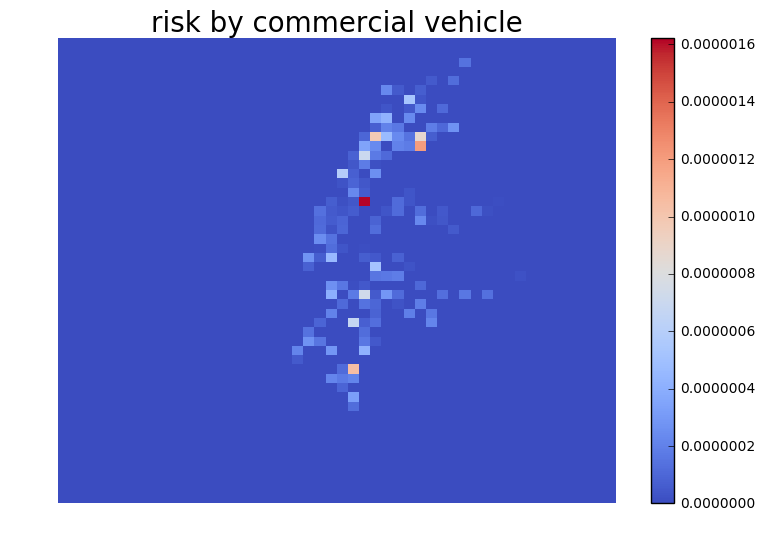

In [345]:
comm_inj_normalized = getNormalizedInjuries(comm_inj, passenger_array)
showheatmap_bygrid(comm_inj_normalized, 51, 'risk by commercial vehicle')

In [198]:
maxcomm = comm_inj_normalized.max()
np.where(comm_inj_normalized==maxcomm)

(array([32], dtype=int64), array([27], dtype=int64))

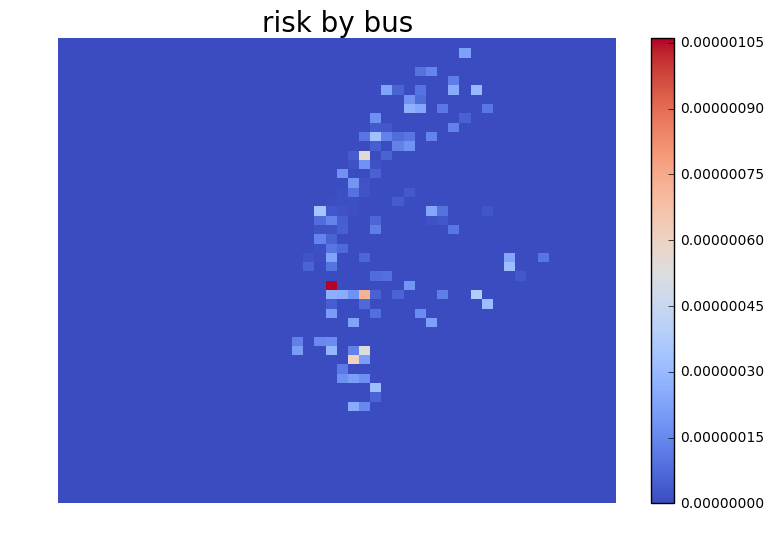

In [346]:
bus_inj_normalized = getNormalizedInjuries(bus_inj, passenger_array)
showheatmap_bygrid(bus_inj_normalized, 51, 'risk by bus')

In [180]:
bus_inj_normalized.max()

1.0600338698488648e-06

In [181]:
np.where(bus_inj_normalized >= 1.0600338698488648e-06 )

(array([23], dtype=int64), array([24], dtype=int64))

In [193]:
def getlatlong(a,b):
    return gridx[b],gridx[b+1], gridy[a],gridy[a+1]

In [194]:
getlatlong(24,23)

(-73.999721592, -73.988642896000002, 40.697610623999999, 40.705888199999997)

In [399]:
getlatlong(31,38)

(-73.833541151999995,
 -73.822462455999997,
 40.755553655999996,
 40.763831232000001)

In [199]:
passenger_array[32,27]

2467952.0

In [200]:
taxi_inj[32,27]

12.0

## normalize both accident and passenger first

In [347]:
pa_new = (passenger_array - passenger_array.mean())/\
            (passenger_array.max()-passenger_array.min())
#pa_new = (passenger_array - passenger_array.mean())/\
#            (passenger_array.std())

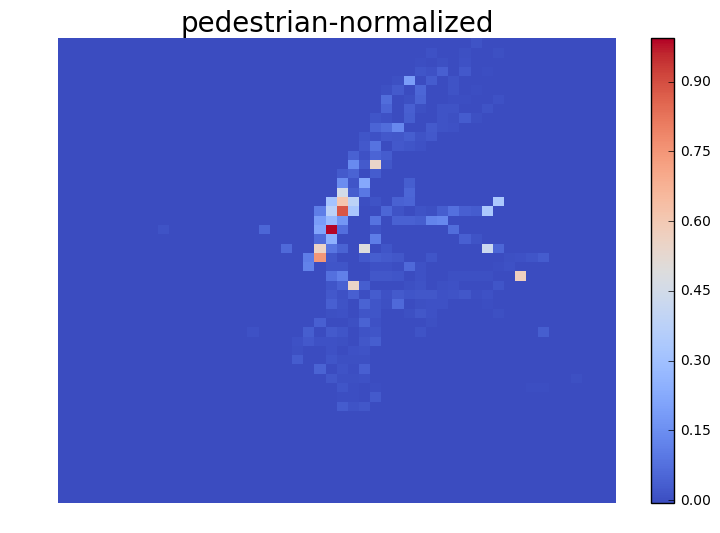

In [348]:
showheatmap_bygrid(pa_new,51,'pedestrian-normalized')

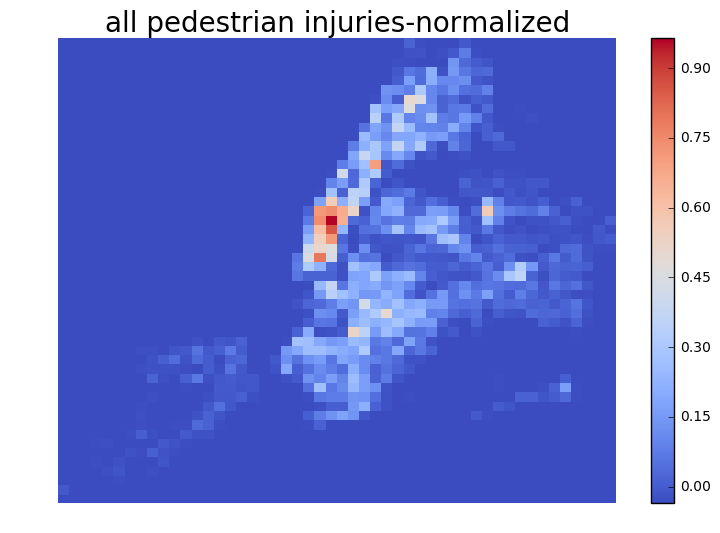

In [349]:
all_new = (pedgrid[0] - pedgrid[0].mean())/(pedgrid[0].max()-pedgrid[0].min())
showheatmap_bygrid(all_new,51,'all pedestrian injuries-normalized')

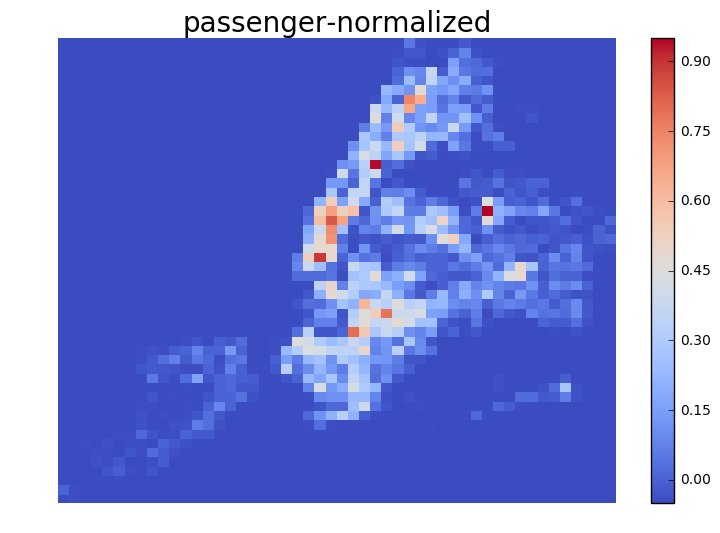

In [350]:
#pass_new = (pass_inj - pass_inj.mean())/(pass_inj.std())
pass_new = (pass_inj - pass_inj.mean())/(pass_inj.max()-pass_inj.min())
showheatmap_bygrid(pass_new,51,'passenger-normalized')

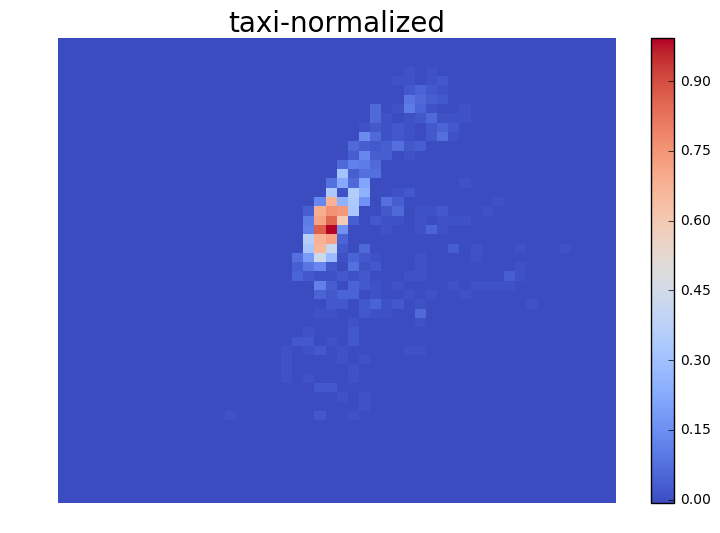

In [351]:
#taxi_new = (taxi_inj - taxi_inj.mean())/(taxi_inj.std())
taxi_new = (taxi_inj - taxi_inj.mean())/(taxi_inj.max()-taxi_inj.min())
showheatmap_bygrid(taxi_new,51,'taxi-normalized')

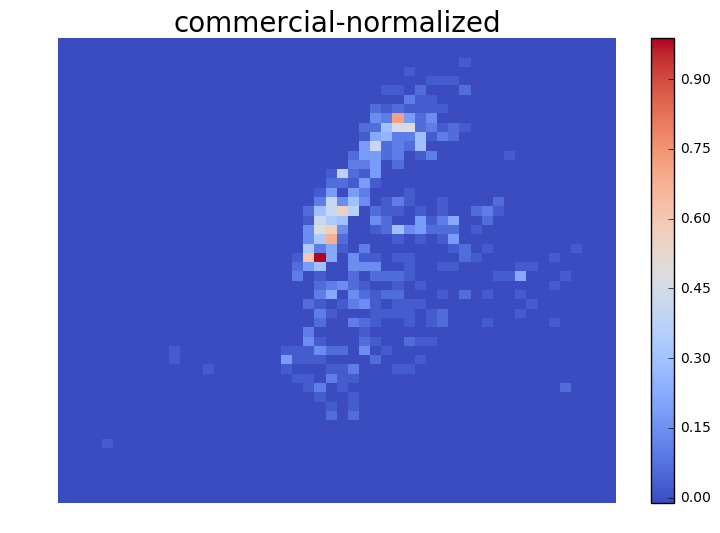

In [352]:
#comm_new = (comm_inj - comm_inj.mean())/(comm_inj.std())
comm_new = (comm_inj - comm_inj.mean())/(comm_inj.max()-comm_inj.min())
showheatmap_bygrid(comm_new,51,'commercial-normalized')

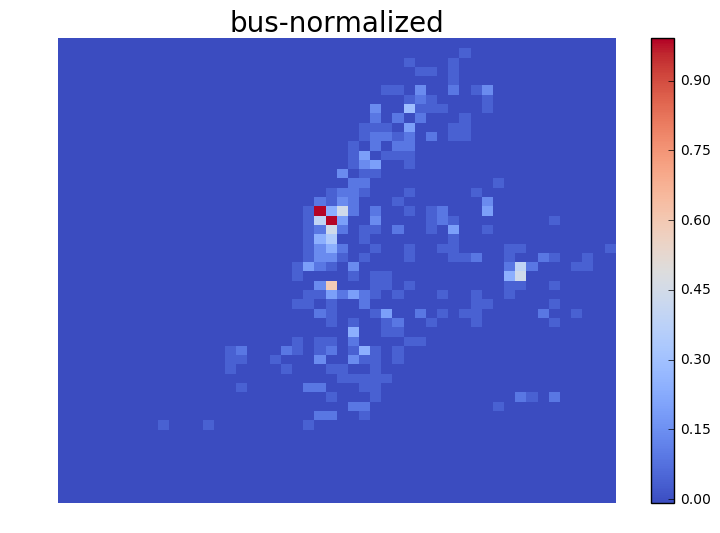

In [353]:
#bus_new = (bus_inj - bus_inj.mean())/(bus_inj.std())
bus_new = (bus_inj - bus_inj.mean())/(bus_inj.max()-bus_inj.min())
showheatmap_bygrid(bus_new,51,'bus-normalized')

### getnormalized injuries

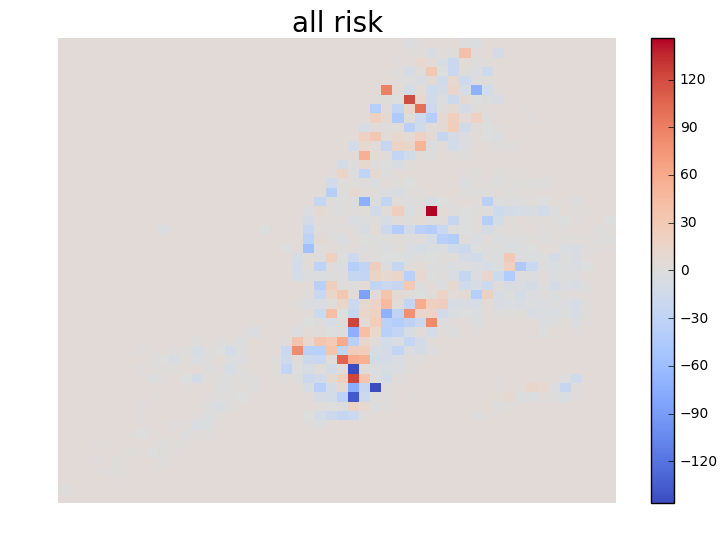

In [354]:
all_inj_normalized2 = getNormalizedInjuries(all_new, pa_new)
showheatmap_bygrid(all_inj_normalized2, 51, 'all risk')

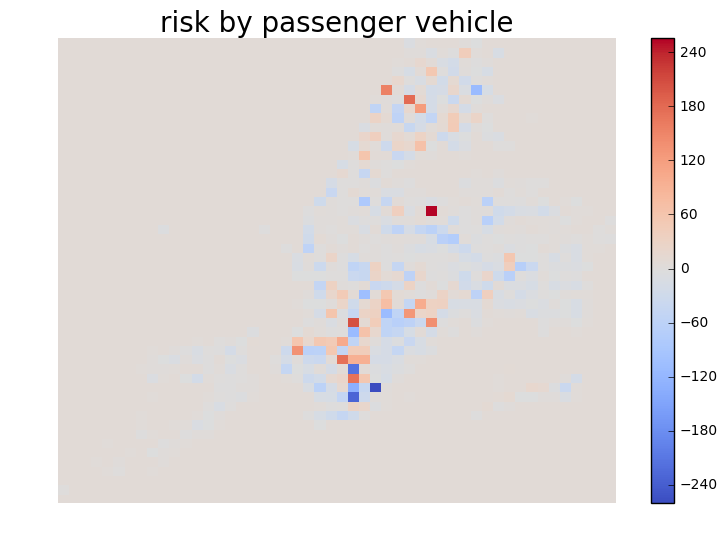

In [355]:
pass_inj_normalized2 = getNormalizedInjuries(pass_new, pa_new)
showheatmap_bygrid(pass_inj_normalized2, 51, 'risk by passenger vehicle')

In [380]:
maxpass=comm_inj_normalized2.max()
np.where(comm_inj_normalized2 > 40)

(array([19, 38, 39], dtype=int64), array([26, 32, 28], dtype=int64))

In [385]:
pass_inj_normalized2[15,26]

95.368178271816035

In [397]:
getlatlong(26,40)

(-73.811383759999998, -73.800305064, 40.714165775999994, 40.722443351999999)

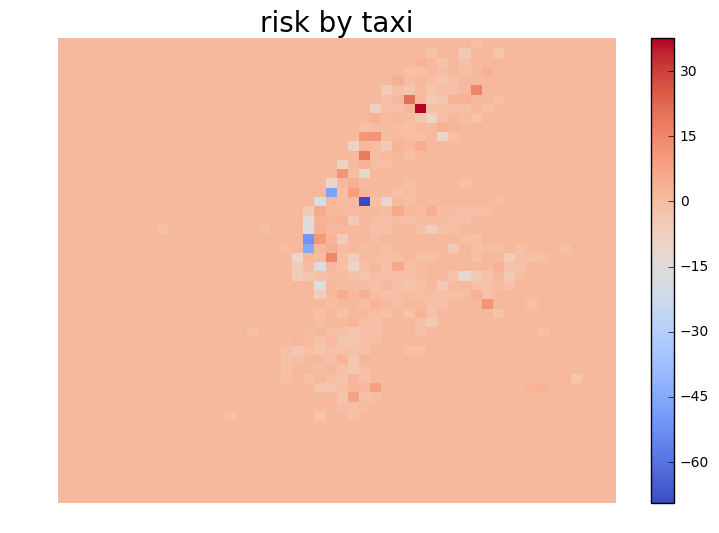

In [356]:
taxi_inj_normalized2 = getNormalizedInjuries(taxi_new, pa_new)
showheatmap_bygrid(taxi_inj_normalized2, 51, 'risk by taxi')

In [359]:
taxi_inj_normalized2[36,28]

0.11047783649965086

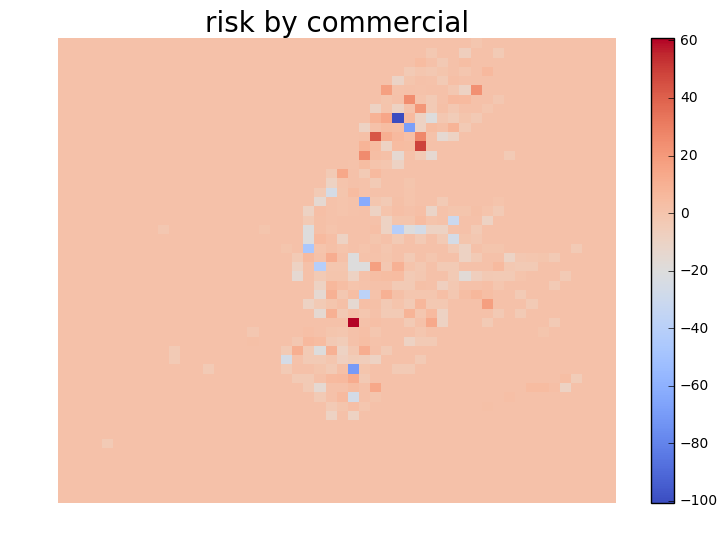

In [357]:
comm_inj_normalized2 = getNormalizedInjuries(comm_new, pa_new)
showheatmap_bygrid(comm_inj_normalized2, 51, 'risk by commercial')

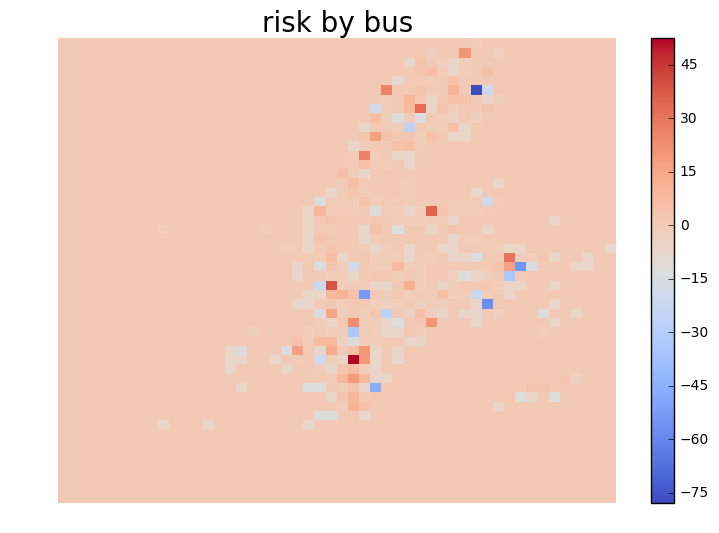

In [358]:
bus_inj_normalized2 = getNormalizedInjuries(bus_new, pa_new)
showheatmap_bygrid(bus_inj_normalized2, 51, 'risk by bus')

In [396]:
a = bus_inj_normalized2.max()
np.where(bus_inj_normalized2 >30)

(array([15, 23, 26, 31, 42], dtype=int64),
 array([26, 24, 40, 33, 32], dtype=int64))

In [268]:
passenger_array[30,23]

97952563.0

In [269]:
getlatlong(31,23)

(-73.999721592, -73.988642896000002, 40.755553655999996, 40.763831232000001)

In [270]:
passenger_array[31,24]

195601304.0

In [298]:
all_passenger.head()

,UNIT,0,lat,long,digx,digy
0,R001,24915371.0,40.703082,-74.012983,25,22
1,R003,1500994.0,40.689945,-73.872564,24,35
2,R004,4011298.0,40.691320,-73.867135,24,35
3,R005,3970681.0,40.692304,-73.860151,24,36
4,R006,4554574.0,40.693866,-73.851568,24,37


In [366]:
passenger_array

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [6]:
with open('boundaries.geojson') as f:
    boundaries = pd.DataFrame(json.load(f))